# RockingData Challenge

## Marketing para un banco de Portugal

Data Scientist: Santiago Tedoldi

https://github.com/sstedoldi/marketing

Usando anaconda env

> conda create --name marketing python=3.11

> conda install --yes --file requirements.txt

Para app, ver archivo steps.txt


## Librerias

In [1]:
import numpy as np
import pandas as pd
import tqdm as notebook_tqdm
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from modules.utils_eda import summary_statistics,\
                                summary_statistics_comparative,\
                                plot_distributions,\
                                plot_distributions_by_cluster,\
                                distanceMatrix


## EDA

### Análisis express usando ydata_profiling

Esta librería procesa las variables del dataset, una a una, evaluando:

- Tipo de dato
- Estadísticos básicos (mean, min, max)
- Distribuciones
- Uniques, Missing, Infinite, Zeros
- Duplicados
- Interacciones o pairplots de numéricas
- Correlación entre numéricas de numéricas

Este tipo de herramientas permite un rápido vistazo, para luego profunzidar en lo que amerita.

Limitante: resulta lento o impracticable con un dataset de cientos de variables, lo que amerita evaluar la relevancia de variables de forma previa.

In [2]:
df_ori = pd.read_csv('data/bank-additional-full.csv', sep=';')

In [3]:
df_ori.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
profile = ProfileReport(df_ori, title="Bank Marketing")

In [5]:
# profile.to_file("EDA_report_Bank_Marketing.html")

## Diccionario de variables

**Bank client data:**

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

**Related with the last contact of the current campaign:**

8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**Other attributes:**

12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

**Social and economic context attributes**

16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

17 - cons.price.idx: consumer price index - monthly indicator (numeric)

18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)

19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

20 - nr.employed: number of employees - quarterly indicator (numeric)

**Output variable (desired target):**

21 - y - has the client subscribed a term deposit? (binary: 'yes','no')


## Data Quality

### Missing

En la información se aclara que hay missing values en variables categóricos. 

En realidad, el dataset provisto los tiene indicados como "unkown".

Estas son:

- marital < 1 %
- education 4 %
- default 21 %
- housing 2 %
- loan 2 %

In [6]:
### NO SE TOMAN MEDIDAS

### Duplicates

Encontramos una mínima cantidad de missing values.

+ Resulta práctico eliminar estos duplicados

In [7]:
df_ori.drop_duplicates(inplace=True)

## Data Drifting

Al tratarse de un dataset atemporal, o una única foto extraída sin datos históricos, el data drifting no es un problema.

**Consideraciones a futuro:**

> En futuras versiones del modelo, con info de los clientes en distintos períodos de tiempo (meses por ejemplo), esto debe ser revisado.

In [8]:
### NO APLICA

## Feature engineering

La ingeniería de variables resulta un paso crucial en el desarrollo de modelos predictivos. 

En este challenge, parece que el dataset ya fue "curado" y con variables pre-seleccionadas por algún método. Esto limita, limita severamenta la posibilidad de crear nuevas features.

De todos modos de crean dos indicadores:

+ 'no_previous_contact': Sin contacto previo (X No creo que sea necesario para su explotación por modelos de árboles)
+ 'not_working': No económicamente activos


In [9]:
# df_ori['no_previous_contact'] = np.where(df_ori['pdays'] == 999, 1, 0)
df_ori['not_working'] = np.where(np.in1d(df_ori['job'], ['student', 'retired', 'unemployed']), 1, 0)

**Consideraciones a futuro:**

> Contar con un dataset temporal, al menos que defina el tiempo presente, permitará trabajar con diferencias de fechas (por ejemplo con dias/semanas desde el último contacto).

> Contar otros datos de los clientes, variables como: balance, ingresos, gastos, transacciones, deudas y productos bancarios; puede ser muy benificioso para mejorar el perfomance de la solución.

Deberíamos contar con 100 a 200 variables crudas.

> Conocer la normativa de Portugal, respecto al pago de aguinaldos, sería bueno para saber que meses pueden ser más productivos para colocar plazos fijos.

## Target

La variable objetivo y, que parece indicar la conversión de la venta de "plazo fijo", tiene ~11 % de casos positivos y ~89 negativos.

Este desbalance no motiva, a priori, tomar ninguna medida de balanceo. Sin embargo, sí sesga métricas como el accuracy.

## Ventas vs. no-venta

Para entender las condiciones de venta vs. los casos donde las campaña no fue exitosa, se procede a visualizar los datos según la variable target.

In [10]:
target = 'y' 

print("Resumen Estadístico - Comparativo")
key1= 'yes'
key2= 'no'
stats=['count', 'mean', '50%', 'std']
summary_stats_combined = summary_statistics_comparative(df_ori.loc[df_ori[target] == key1], 
                                                        df_ori.loc[df_ori[target] == key2], 
                                                        key1, key2, stats=stats)
print(summary_stats_combined.to_markdown())


Resumen Estadístico - Comparativo
|                |   ('yes', 'count') |   ('no', 'count') |   ('yes', 'mean') |   ('no', 'mean') |   ('yes', '50%') |   ('no', '50%') |   ('yes', 'std') |   ('no', 'std') |
|:---------------|-------------------:|------------------:|------------------:|-----------------:|-----------------:|----------------:|-----------------:|----------------:|
| age            |               4639 |             36537 |         40.9123   |       39.911     |           37     |          38     |        13.8388   |        9.89718  |
| duration       |               4639 |             36537 |        553.256    |      220.868     |          449     |         164     |       401.191    |      207.116    |
| campaign       |               4639 |             36537 |          2.05195  |        2.63339   |            2     |           2     |         1.66635  |        2.87377  |
| pdays          |               4639 |             36537 |        791.991    |      984.109     |   

Graficando distribuciones y frecuencias según target
Variables numéricas


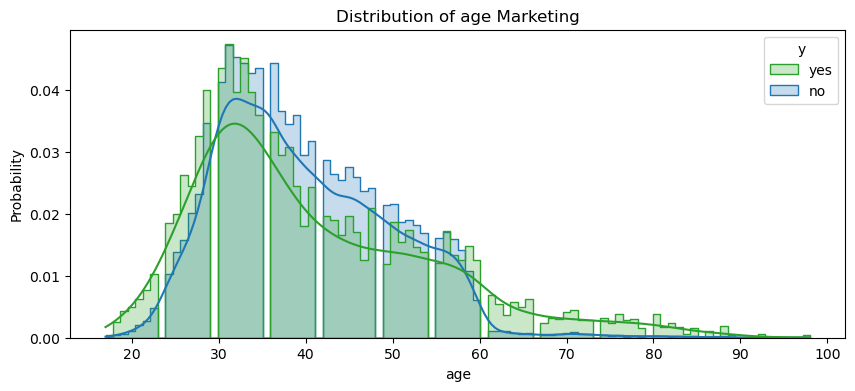

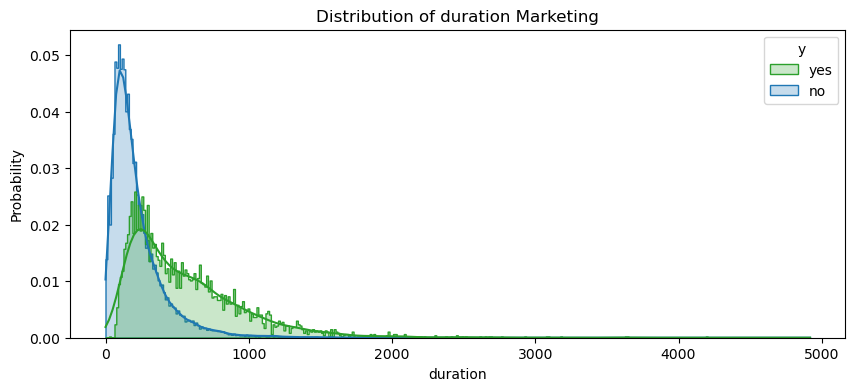

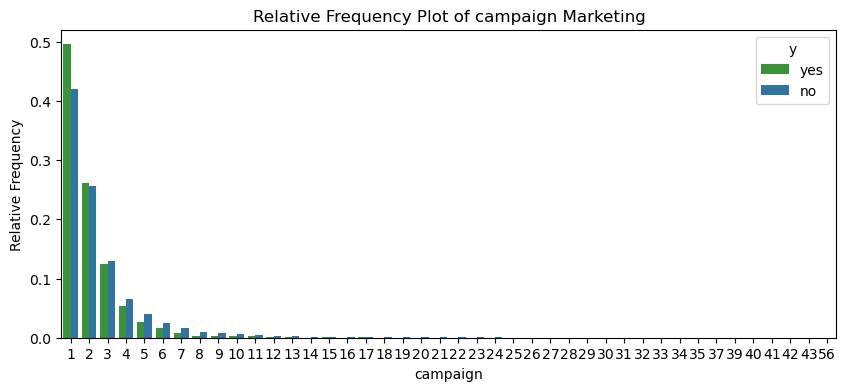

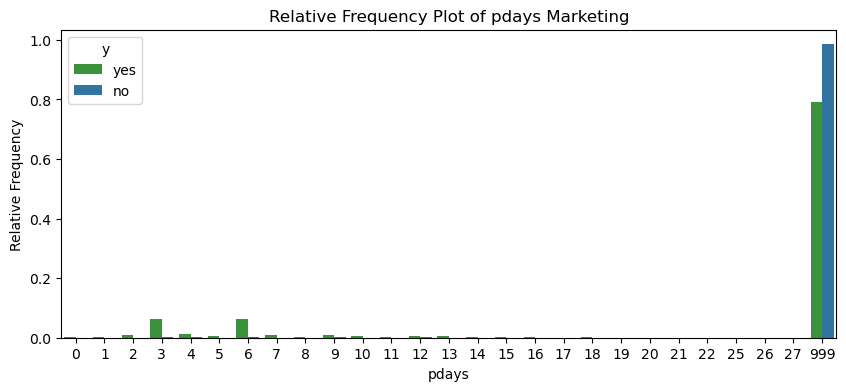

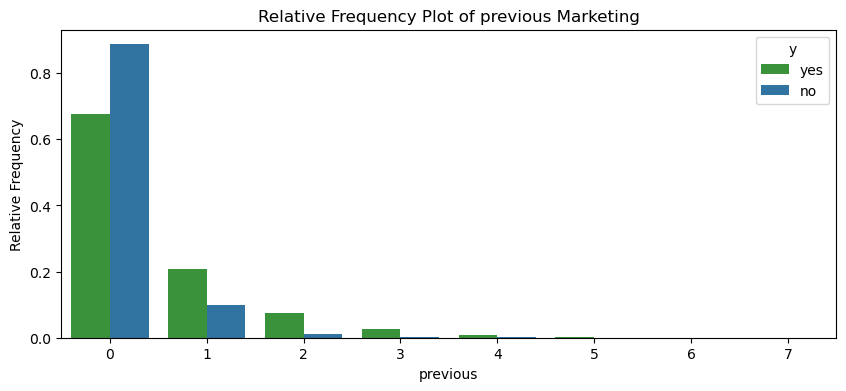

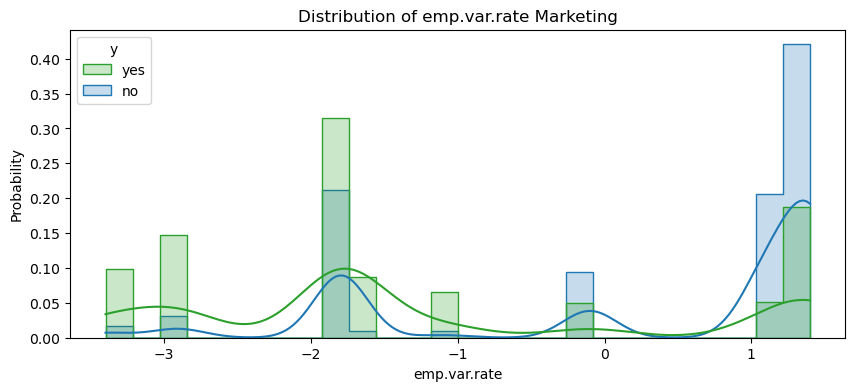

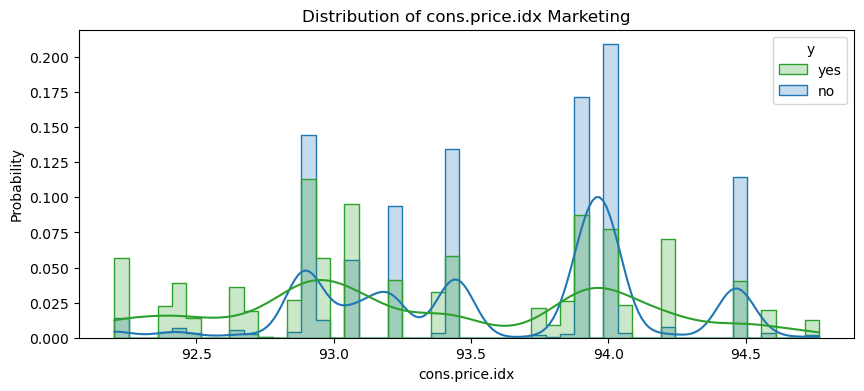

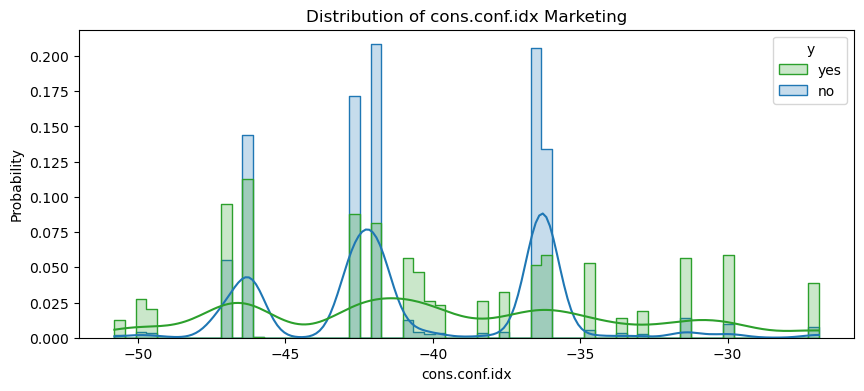

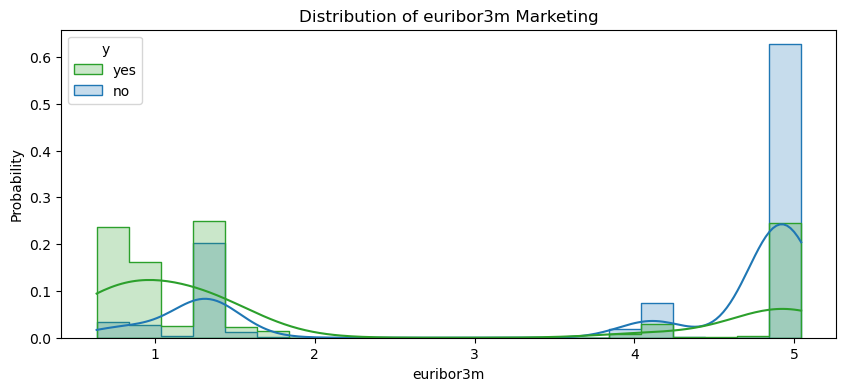

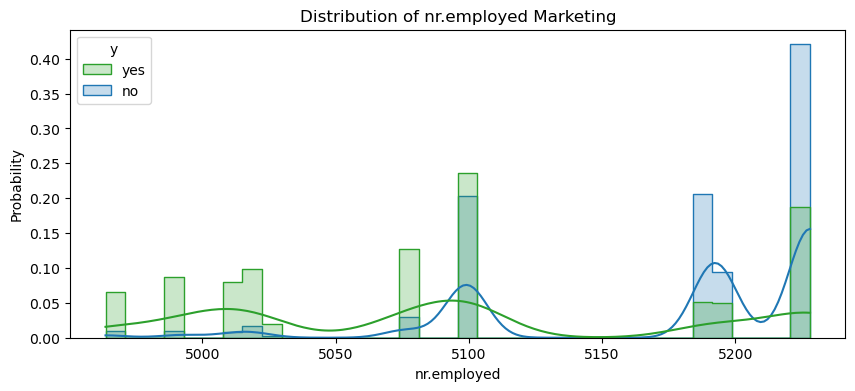

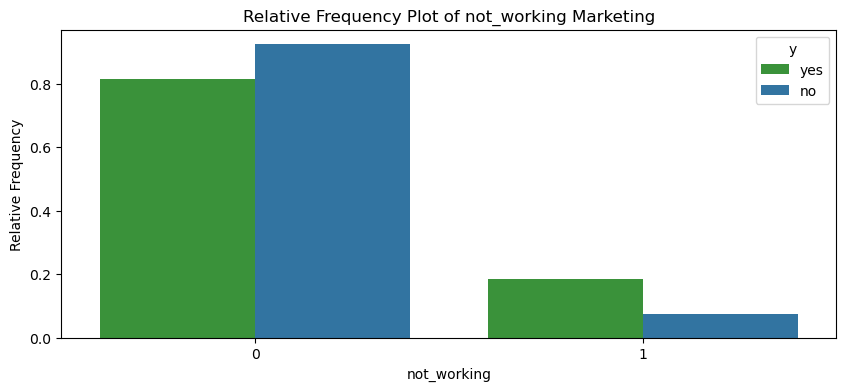

Variables categóricas o booleanas


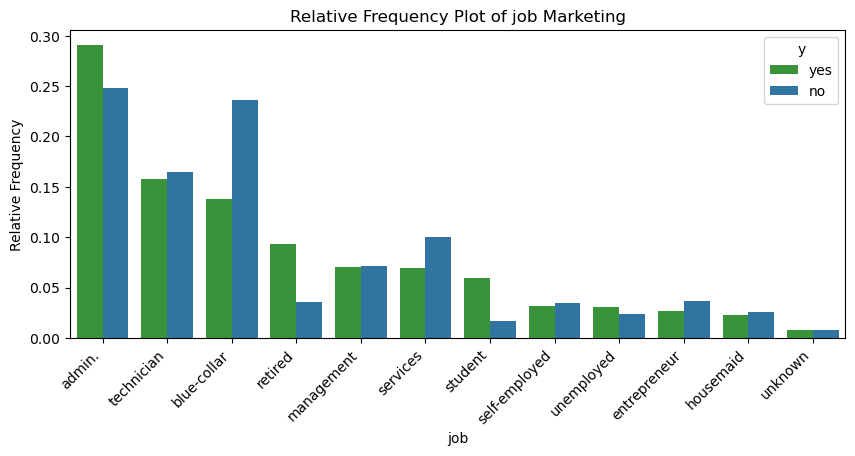

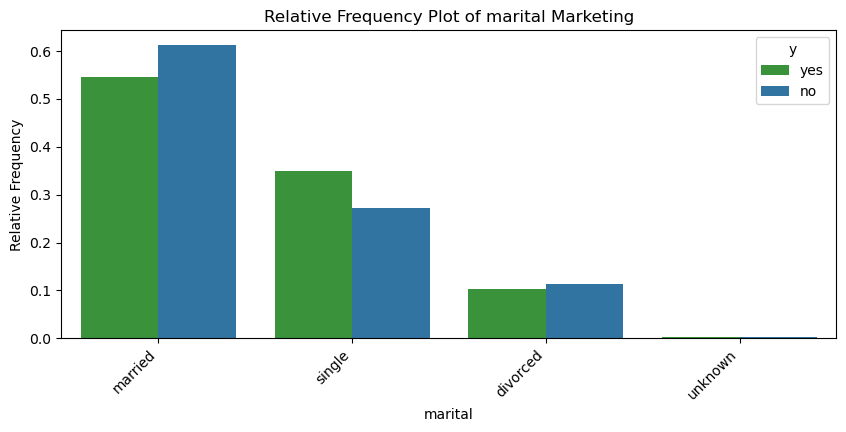

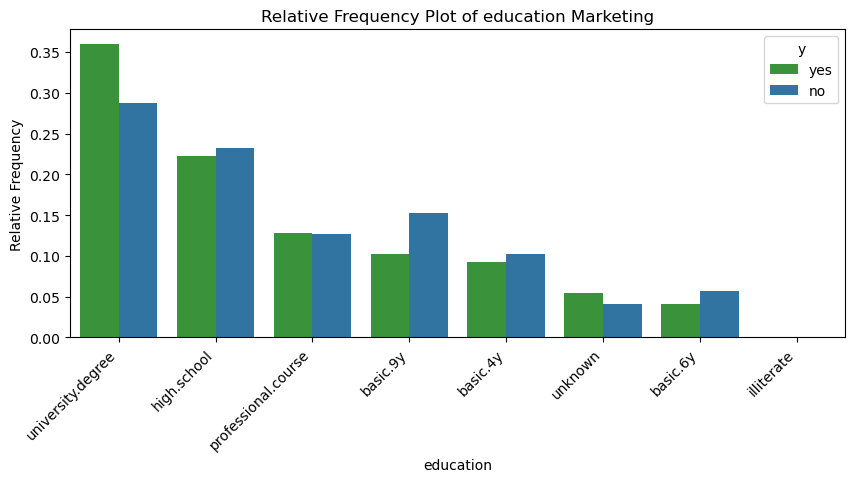

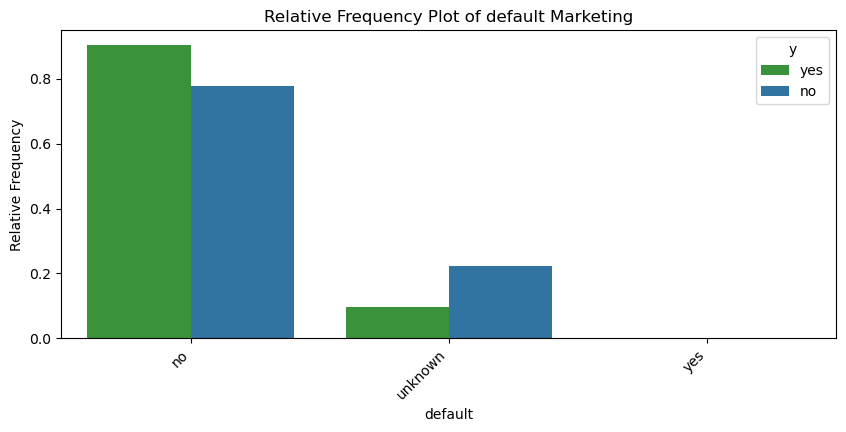

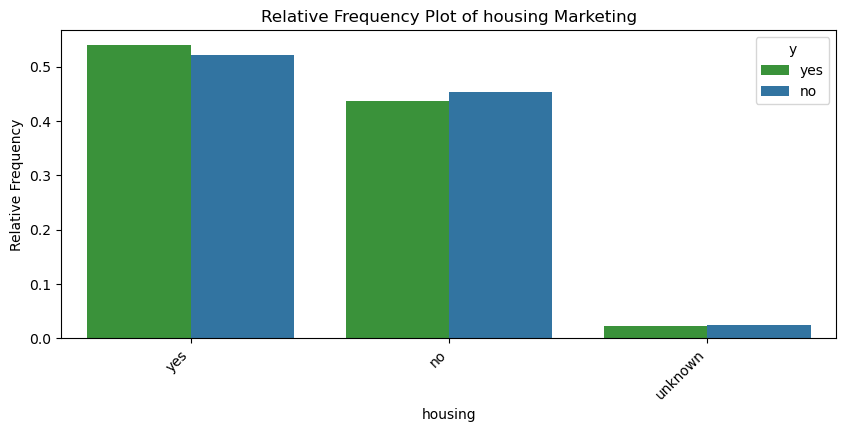

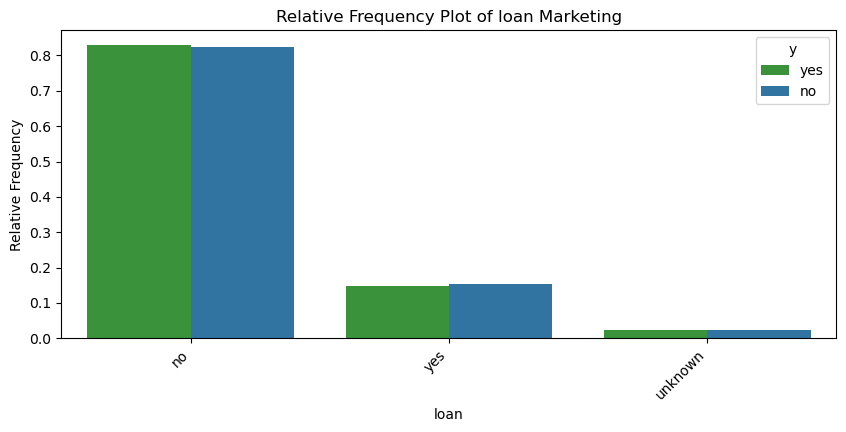

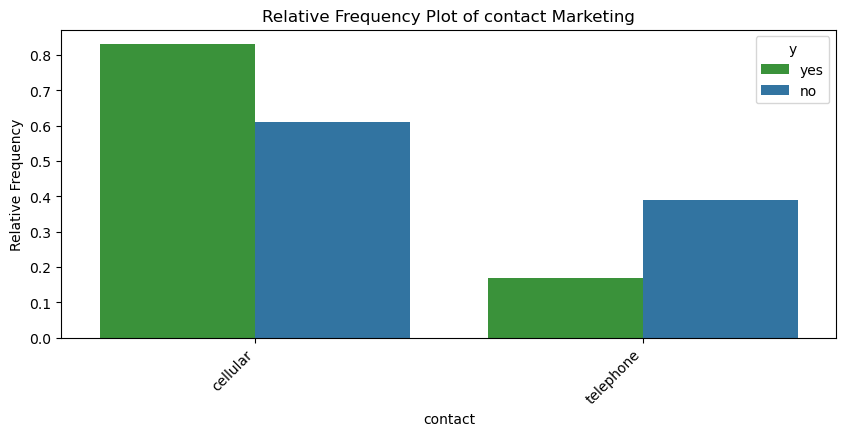

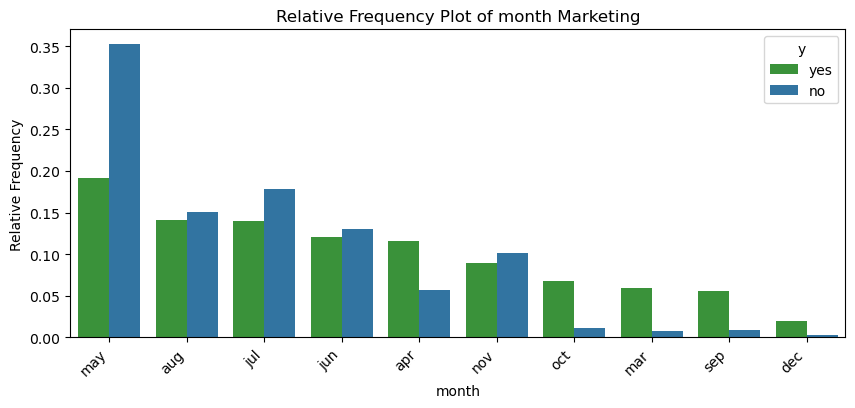

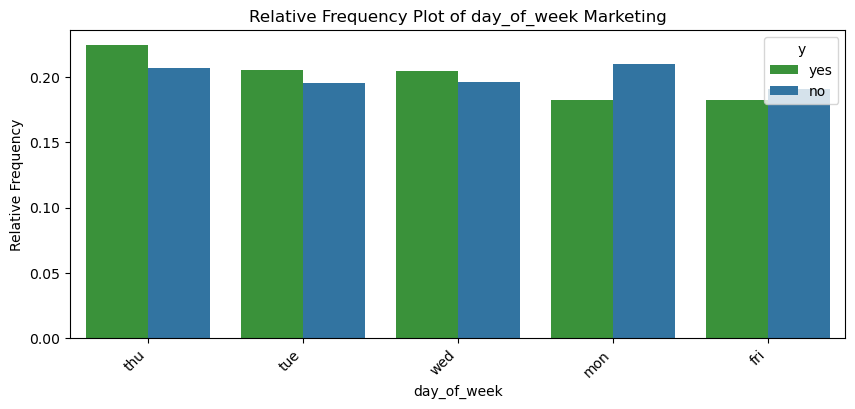

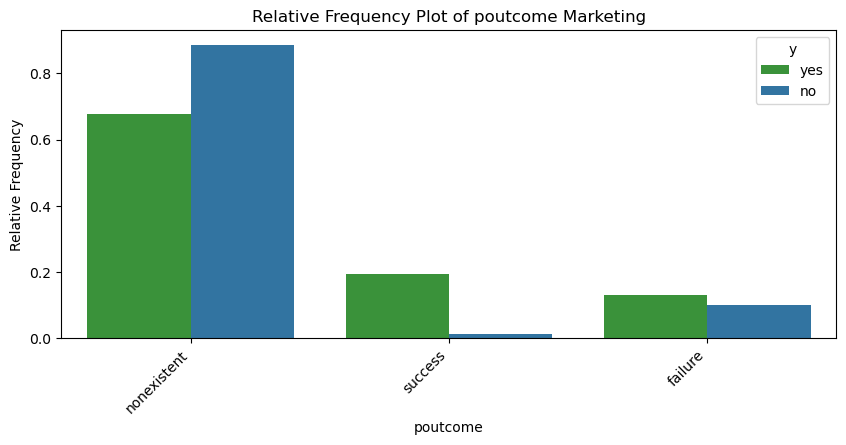

In [11]:
print("Graficando distribuciones y frecuencias según target")

# convirtiendo algunas variables a float para mejor visualización
df_ori.age = df_ori.age.astype(float)
df_ori.duration = df_ori.duration.astype(float)


plot_distributions(df_ori, target=target, title_suffix='Marketing',sample_frac=1)

OBSERVACIONES:

En un análisis general de la distribución/frequencuas de las variables, según resultado de venta hay mucho para observar. En este análisis, solo se describen algunos insights:

> age: las ventas son más efectivas en clientes sub-30 y mayores de 60

> duration: lógicamente, las conversiones se distribuyen en conversaciones más prolongadas.

> campaing: el 50 % de las conversiones se da un 1ros contactos, un 25 % en los 2dos y ~10 % en los 3ros. por encima de los 10 contactos, la ganancia es despreciable.

> pdays: dejar pasar > 2 días parece conveniente, para los próximos contactos.

> emp.var.rate: parece que hay más conversiones cuando la tasa de empleo cae, quizás cuando las personas priorizan cuidar sus ahorros, y no gastar.

> eoribor3m: hay menos plazos fijos colocados a una tasa del euribor alta.

> not_working: los studiantes y retirados tienen a aceptar más plazos fijos, en comparación a la gente económicamente-activa.

> education: university.degree son mejores prospecrtos que el resto.

> contact: el celular es un mejor medio para ventas.

> month: hay meses donde la efectividad relativa aumenta considerablemente, por algún motivo, quizás de negocio (tasa de interés ofrecido o similar).

> day_of_wee: los lunes y los viernes son un poco menos efectivos.

## Segmentación de las ventas

Para un mejor entendimiento del caso, se procede a segmentar el dataset, para entender las características de los clientes y el contexto en el cuál se convierte.

**Técnica de segmentación**

> RandomForest (RF) para procesar los datos sin fines predictivos:

Se utilizan las hojas activas (como cross features) para medir coincidencias de las muestras en dichas hojas, tomando esto como medida de disimilitud/distancia.

> UMAP para procesar la matriz de disimilitud/distancia del RF

Crea un embedding de dos dimensiones, que permite tanto visualizar como trabajar de manera práctica la representación de las muestras, según su disimilitud/distancia. Similar a t-SNE.

> DBSCAN para crear clusters:

Partiendo de la matriz de disimilitud/distancia creada a partir del RF.

In [12]:
from sklearn.ensemble import  RandomForestClassifier
from umap import UMAP
from sklearn.cluster import DBSCAN

seed=42

### Undersampleo de casos negativos

Para reducir el costo computacional del calculo de la matriz de distancia entre muestras, que sería BigO N^2, vamos a undersamplear pero solo los casos negativos.

In [13]:
pos_index = df_ori.loc[df_ori['y']=='yes'].index
neg_index = df_ori.loc[df_ori['y']=='no']\
    .sample(len(pos_index), random_state=seed).index

under_index = pos_index.union(neg_index)

df_under = df_ori.loc[under_index]

### RandomForest para medir distancia

La simpleza del RF Classifier requiere el encoding de categóricas.

En este caso, no se preve incoveniente de usar un aproach simple como one-hot. En casos con categórticas con cientos de valores únicos, se deberá utilizar alguna técnica de emdebbing o similar.

NOTA: 

> No se usa un split de validación/testeo, porque en esta segmentación el fin no es predecir, sino explorar los datos.

In [14]:
X_rf = df_under.drop([target], axis=1)
y_rf = df_under[target]

num_features = X_rf.select_dtypes(include=np.number).columns.tolist()
cat_features = X_rf.drop(num_features, axis=1).columns.tolist()

X_encoded = pd.get_dummies(X_rf, columns=cat_features)

model = RandomForestClassifier(n_estimators=100,
        max_depth=28,
        max_features=0.3,
        min_samples_leaf=138,
        min_samples_split=5,
        max_samples=0.7,
        random_state=seed,
        n_jobs=-1,
        oob_score=True)

model.fit(X_encoded, y_rf)

RandomForestClassifier(max_depth=28, max_features=0.3, max_samples=0.7,
                       min_samples_leaf=138, min_samples_split=5, n_jobs=-1,
                       oob_score=True, random_state=42)

Función que calcula la **matriz de distancias** a partir del bosque entrenado.

In [15]:
# md = distanceMatrix(model, X_encoded)

# np.save('eda/distance_matrix_under.npy', md)

md = np.load('eda/distance_matrix_under.npy')

### UMAP (Uniform Manifold Approximation and Projection)

Permite tanto visualizar como trabajar de manera práctica la "representación latente" de las muestras, según su disimilitud/distancia. Similar a t-SNE.

In [16]:
embedding_rf = UMAP(n_components=2,
                    n_neighbors=50,
                    metric="precomputed",
                    random_state=seed).fit_transform(md)

embedding_rf

c:\Users\santt\.conda\envs\marketing\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\santt\.conda\envs\marketing\Lib\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\santt\.conda\envs\marketing\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


array([[19.336224 ,  5.3913107],
       [20.661345 ,  7.1883583],
       [19.52303  ,  5.296892 ],
       ...,
       [ 5.2295737, -3.7412097],
       [ 5.1916947, -3.693321 ],
       [ 5.076918 , -3.6169357]], dtype=float32)

Agregando predicciones del RF, solo a modo fin de identificar donde se localizan las ventas en el espacio vectorial del embedding creado.

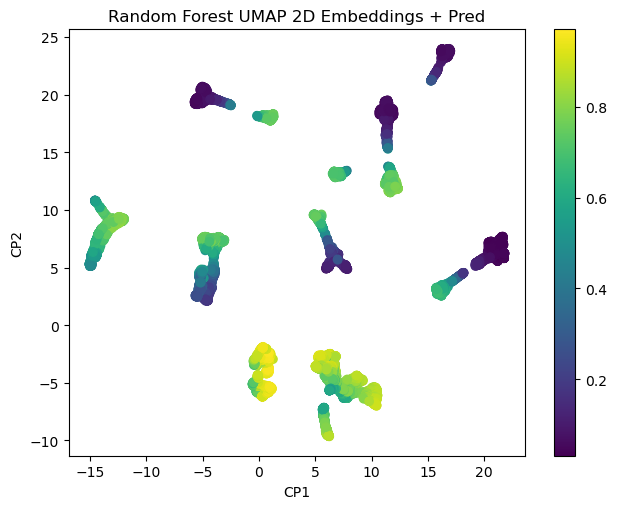

In [17]:
class_index = np.where(model.classes_ == 'yes')[0]
prob_baja = model.predict_proba(X_encoded)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.tight_layout()
plt.colorbar()

plt.title("Random Forest UMAP 2D Embeddings + Pred")

plt.xlabel("CP1")
plt.ylabel("CP2")

plt.show()

OBSERVACIONES:

> En las componentes que creó UMAP se observa la formación "natural" de clusters que, sumando la probabilidad de venta que arroja el RF, muestra clusters con alta proba y otros con baja proba.  

### Clustiering

Aplicación de DBSCAN para agrupar los prospectos. El epsilon es la distancia máxima que permite agrupar dos casos.

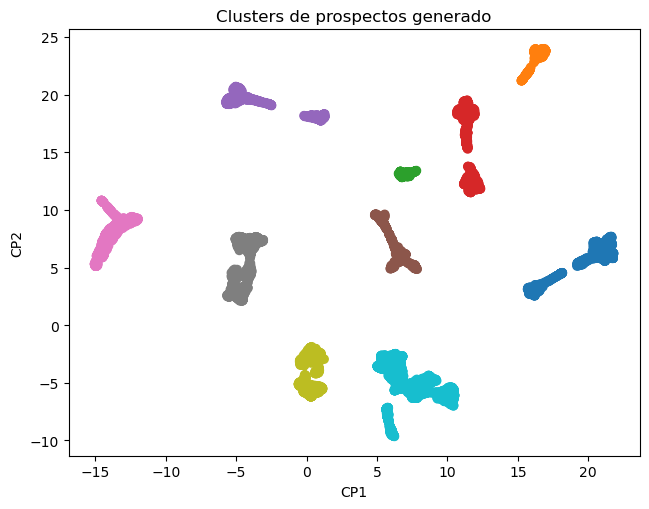

In [18]:
hdb = DBSCAN(eps=3) 
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
plt.tight_layout()

plt.title("Clusters de prospectos generado")

plt.xlabel("CP1")
plt.ylabel("CP2")

plt.show()

NOTA:

> Se ajustó el épsilon para formar 10 clusters, que logran separar lo mejor posible los que tienen alta y baja probabilidad de venta. 

### EDA de los clusters

La proba del RF innecesaria, ya que para todos estos casos tenemos el ground trurh. A continuación, trabajo los clusters según las etiquetas disponibles.

In [19]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

Creación de un dataframe de los casos analizados

Para mejorar la visualización de los clusters

In [20]:
df_clusters = pd.concat([df_under.reset_index(),df_embedding], axis=1)

df_clusters['proba_rf'] = prob_baja

Revelando características de c/cluster

In [21]:
def class_stats(group):
    counts = group['y'].value_counts()
    proportions = group['y'].value_counts(normalize=True)
    return pd.Series({
        'venta_c': counts.get('yes', 0),
        'no-venta_c': counts.get('no', 0),
        'venta_p': proportions.get('yes', 0),
        'no-venta_p': proportions.get('no', 0),
        'proba_rf_mean': group['proba_rf'].mean(),
        'proba_rf_std': group['proba_rf'].std(),
        'proba_rf_min': group['proba_rf'].min(),
        'proba_rf_max': group['proba_rf'].max()
    })

# Aplicar agrupación y agregaciones para los clusters
cluster_stats = df_clusters.groupby('cluster').apply(class_stats).reset_index()

cluster_stats

C:\Users\santt\AppData\Local\Temp\ipykernel_9000\196233041.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_stats = df_clusters.groupby('cluster').apply(class_stats).reset_index()


,cluster,venta_c,no-venta_c,venta_p,no-venta_p,proba_rf_mean,proba_rf_std,proba_rf_min,proba_rf_max
0,0,240.0,958.0,0.200334,0.799666,0.217501,0.246471,0.031290,0.683295
1,1,11.0,462.0,0.023256,0.976744,0.096012,0.062792,0.048919,0.368825
2,2,177.0,44.0,0.800905,0.199095,0.676860,0.071342,0.420322,0.741869
3,3,407.0,774.0,0.344623,0.655377,0.351737,0.324325,0.033724,0.818686
4,4,272.0,644.0,0.296943,0.703057,0.292356,0.290545,0.043673,0.776856
5,5,232.0,456.0,0.337209,0.662791,0.317011,0.258473,0.090328,0.776572
6,6,568.0,268.0,0.679426,0.320574,0.656338,0.102319,0.439577,0.841540
7,7,524.0,684.0,0.433775,0.566225,0.475842,0.216766,0.165615,0.795011
8,8,867.0,41.0,0.954846,0.045154,0.908160,0.065321,0.661684,0.970440
9,9,1341.0,308.0,0.813220,0.186780,0.810992,0.097862,0.500747,0.927320


Visualizando la efectividad de conversión de cada cluster

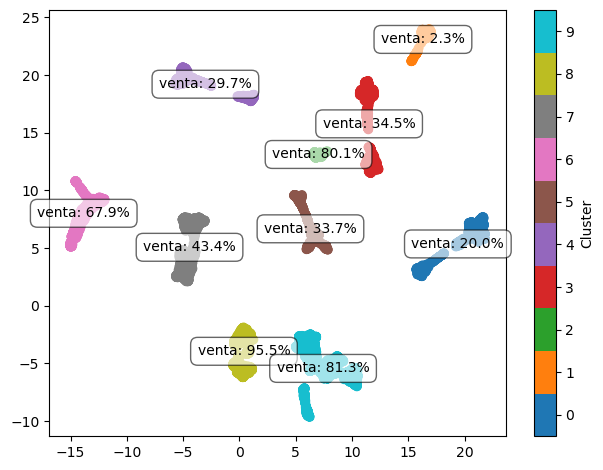

In [22]:
scatter = plt.scatter(df_clusters.embedding_1, df_clusters.embedding_2, c=df_clusters.cluster.astype(int), cmap='tab10')
for idx, row in cluster_stats.iterrows():
    # Tomar el centro aproximado de cada cluster para colocar el texto
    cluster_center = df_clusters[df_clusters['cluster'] == row['cluster']][['embedding_1', 'embedding_2']].mean()
    
    # Formato de las proporciones
    text_label = f"venta: {100*row['venta_p']:.1f}%"
    
    # Añadir texto al gráfico
    plt.text(cluster_center['embedding_1'], cluster_center['embedding_2'], 
             text_label, fontsize=10, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5'))

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
cbar = plt.colorbar(scatter, boundaries=np.arange(df_clusters['cluster'].min() - 0.5, 
                                                  df_clusters['cluster'].max() + 1.5, 1))
cbar.set_ticks(np.arange(df_clusters['cluster'].min(), df_clusters['cluster'].max() + 1))
cbar.set_label('Cluster')

plt.show()

OBSERVACIONES:

> La probabilidad de venta coincide, tal como se esperaba, las probas que arroja el RF entrenado para medir distancia entre muestras.

In [23]:
df_clusters

,index,age,job,marital,education,default,housing,loan,contact,month,...,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,not_working,embedding_1,embedding_2,cluster,proba_rf
0,4,56.0,services,married,high.school,no,no,yes,telephone,may,...,93.994,-36.4,4.857,5191.0,no,0,19.336224,5.391311,0,0.119464
1,6,59.0,admin.,married,professional.course,no,no,no,telephone,may,...,93.994,-36.4,4.857,5191.0,no,0,20.661345,7.188358,0,0.034065
2,13,57.0,housemaid,divorced,basic.4y,no,yes,no,telephone,may,...,93.994,-36.4,4.857,5191.0,no,0,19.523029,5.296892,0,0.118176
3,23,41.0,technician,single,high.school,no,yes,no,telephone,may,...,93.994,-36.4,4.857,5191.0,no,0,21.162910,5.671468,0,0.051692
4,40,58.0,management,unknown,university.degree,no,yes,no,telephone,may,...,93.994,-36.4,4.857,5191.0,no,0,18.133518,4.522429,0,0.176466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9273,41178,62.0,retired,married,university.degree,no,no,no,cellular,nov,...,94.767,-50.8,1.031,4963.6,yes,1,0.329604,-1.940955,8,0.944924
9274,41180,36.0,admin.,married,university.degree,no,no,no,cellular,nov,...,94.767,-50.8,1.028,4963.6,no,0,5.234383,-3.730756,9,0.837421
9275,41181,37.0,admin.,married,university.degree,no,yes,no,cellular,nov,...,94.767,-50.8,1.028,4963.6,yes,0,5.229574,-3.741210,9,0.848960
9276,41183,73.0,retired,married,professional.course,no,yes,no,cellular,nov,...,94.767,-50.8,1.028,4963.6,yes,1,5.191695,-3.693321,9,0.863705


#### Explorando distribuciones en los clusters

Según las variables relevantes (RF) para que una muestra clasifique en su cluster correspondiente

In [24]:
clusters = df_clusters['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_clusters['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  model.fit(X_encoded, y_binary)

  importances = model.feature_importances_
  feature_names = X_encoded.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]


Comparando Cluster 0 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  0 |   12.9123 |    20.0334 |       79.9666 |                   5.17353 |


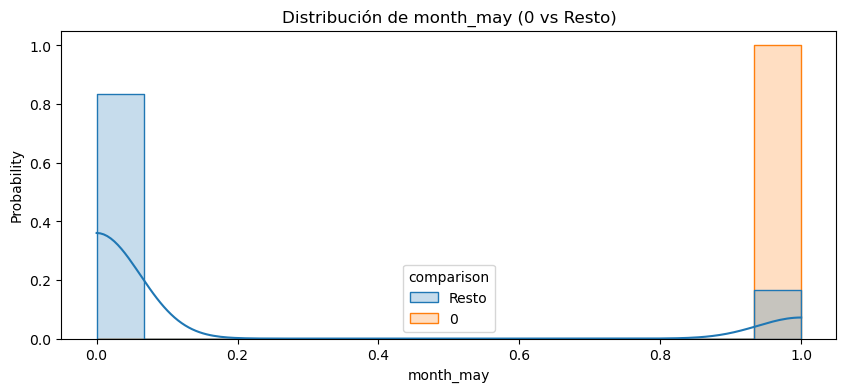

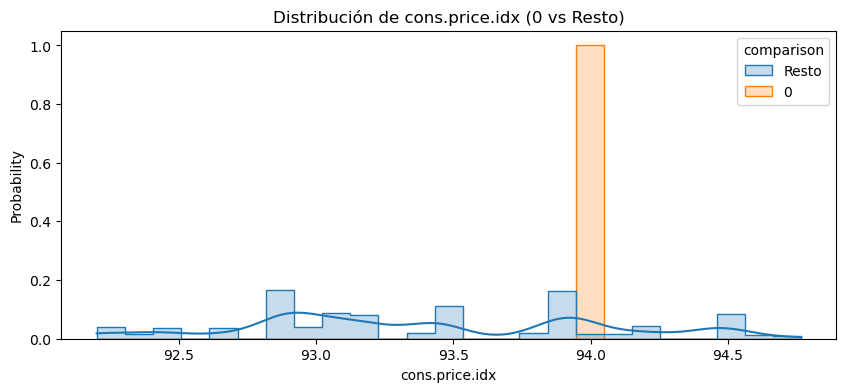

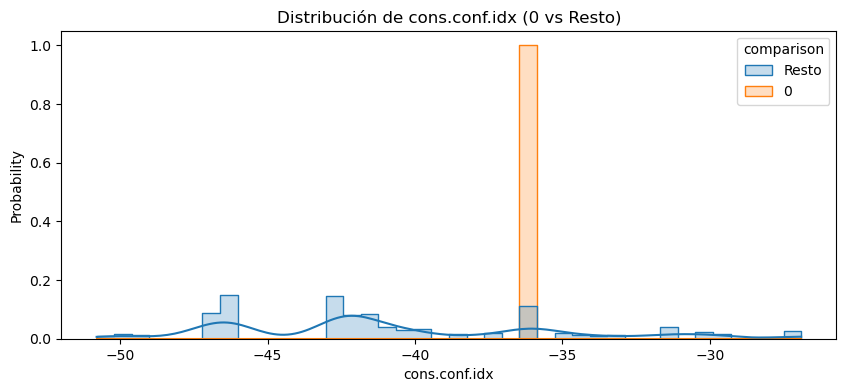


Comparando Cluster 1 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  1 |   5.09808 |    2.32558 |       97.6744 |                   0.23712 |


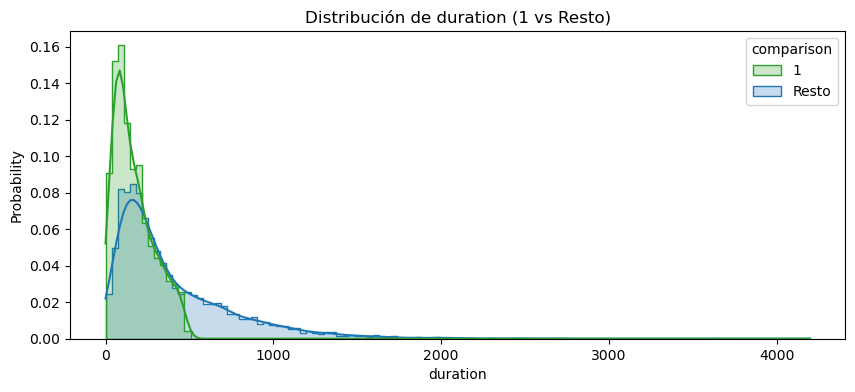

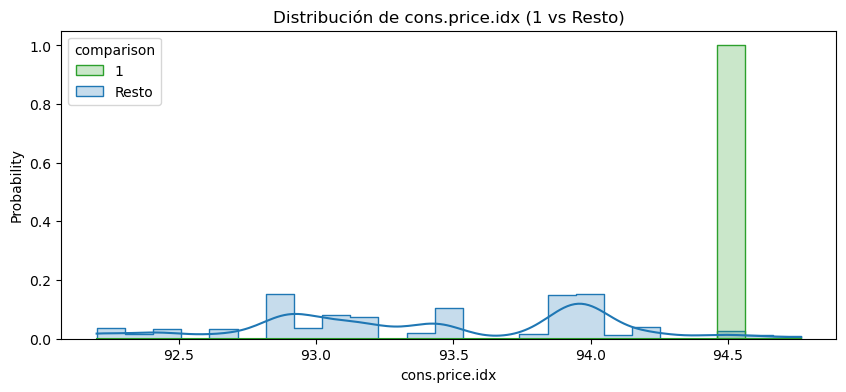

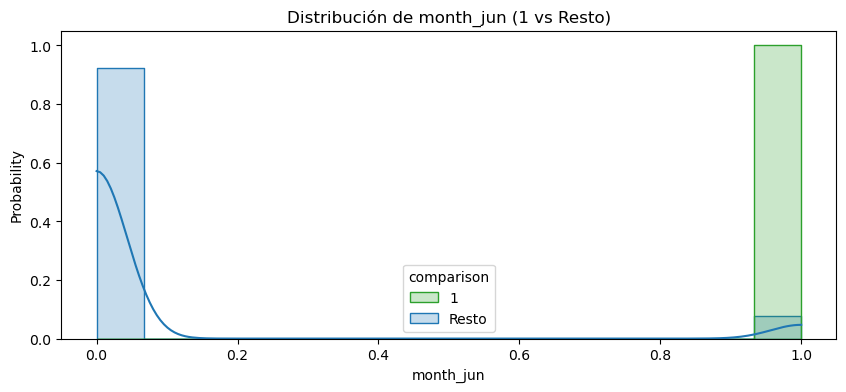


Comparando Cluster 2 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  2 |   2.38198 |    80.0905 |       19.9095 |                   3.81548 |


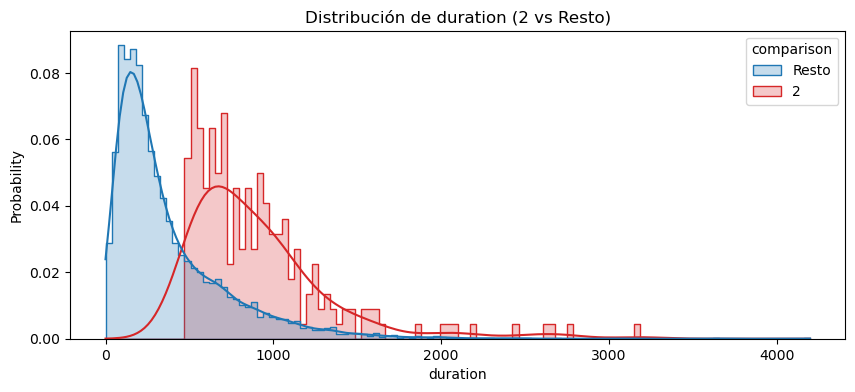

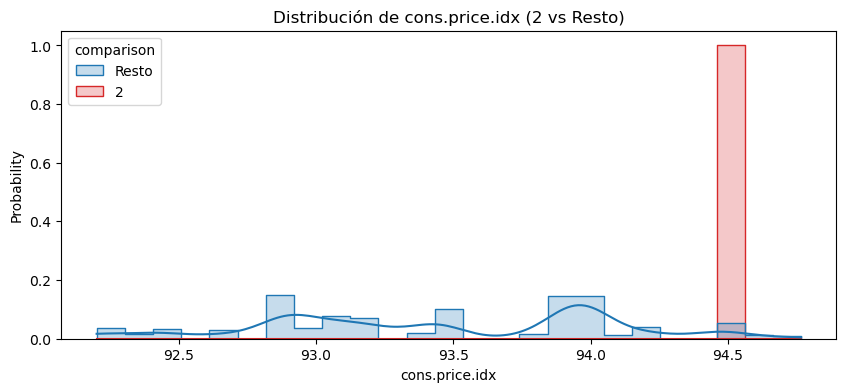

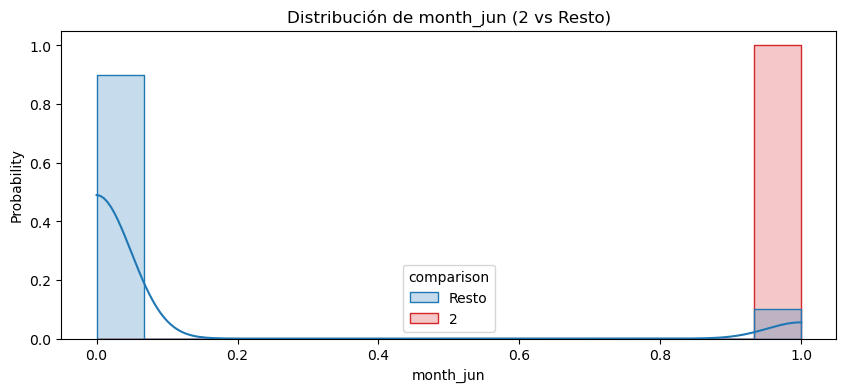


Comparando Cluster 3 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  3 |    12.729 |    34.4623 |       65.5377 |                   8.77344 |


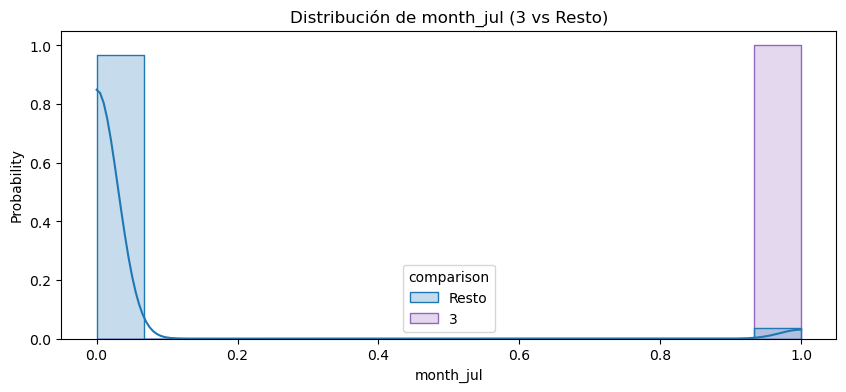

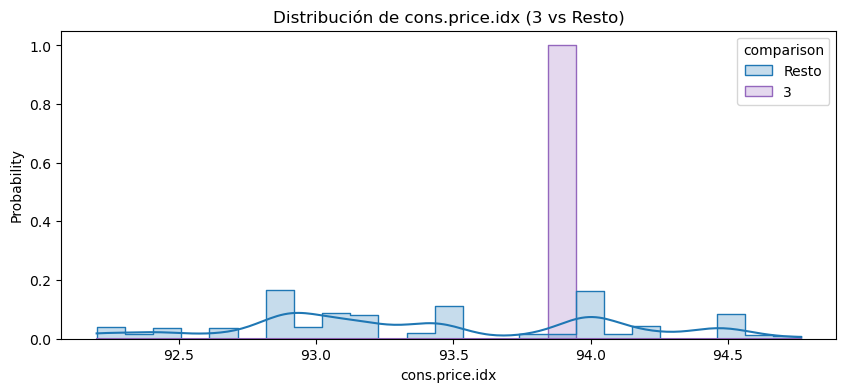

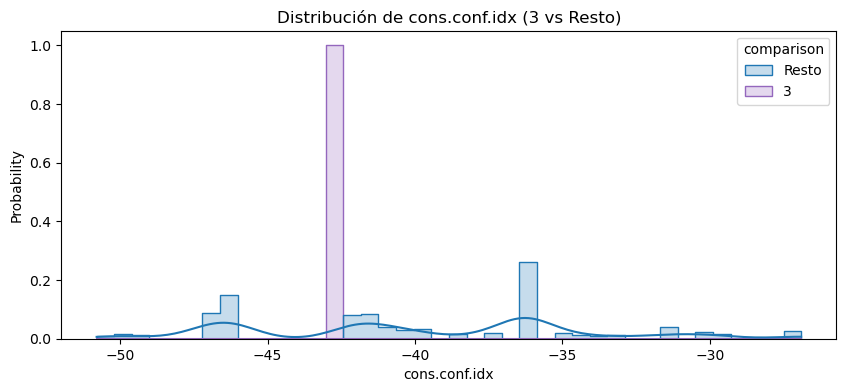


Comparando Cluster 4 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  4 |   9.87282 |    29.6943 |       70.3057 |                   5.86333 |


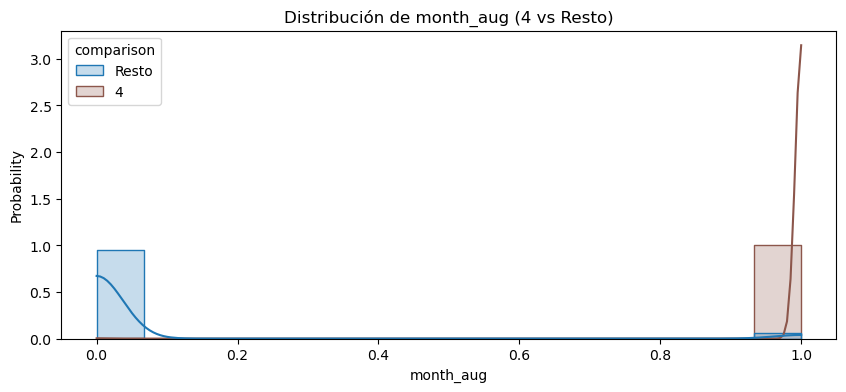

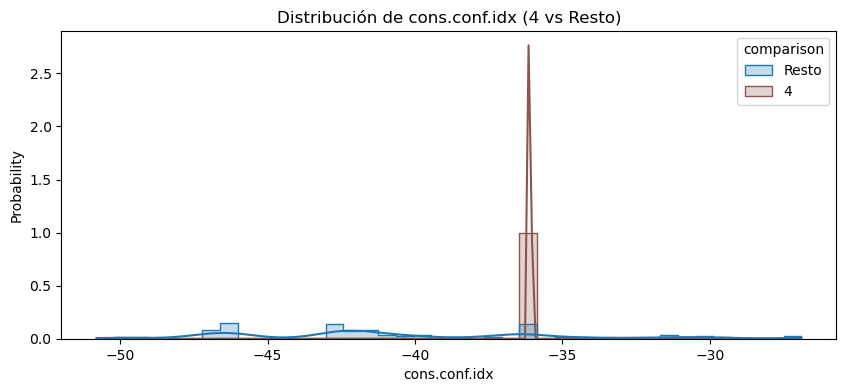

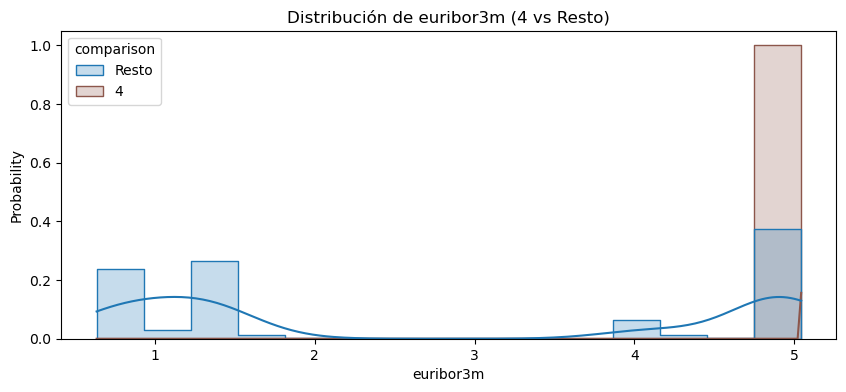


Comparando Cluster 5 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  5 |   7.41539 |    33.7209 |       66.2791 |                   5.00108 |


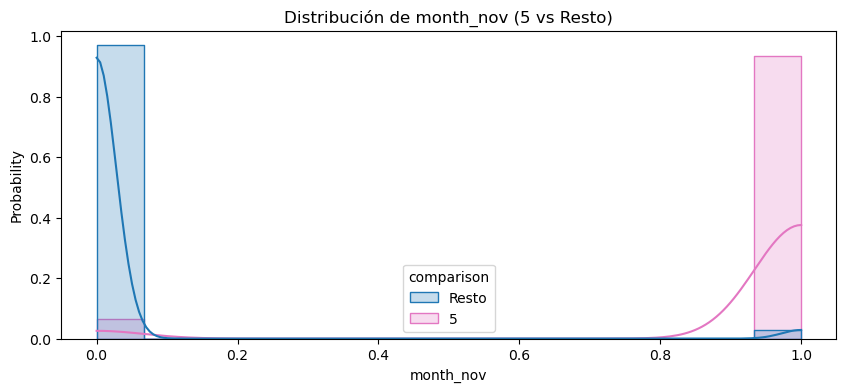

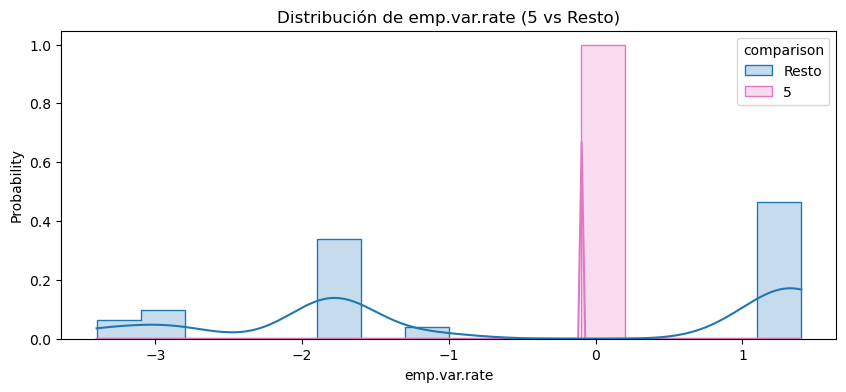

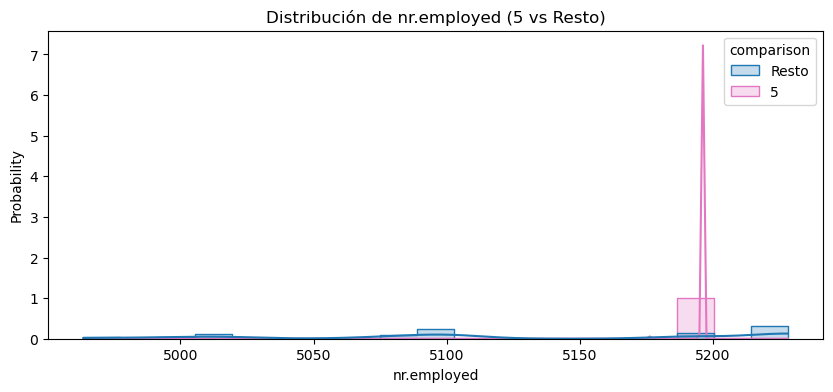


Comparando Cluster 6 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  6 |   9.01056 |    67.9426 |       32.0574 |                    12.244 |


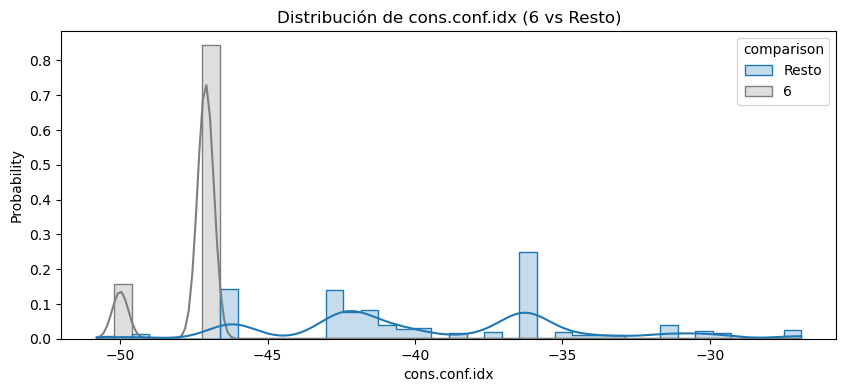

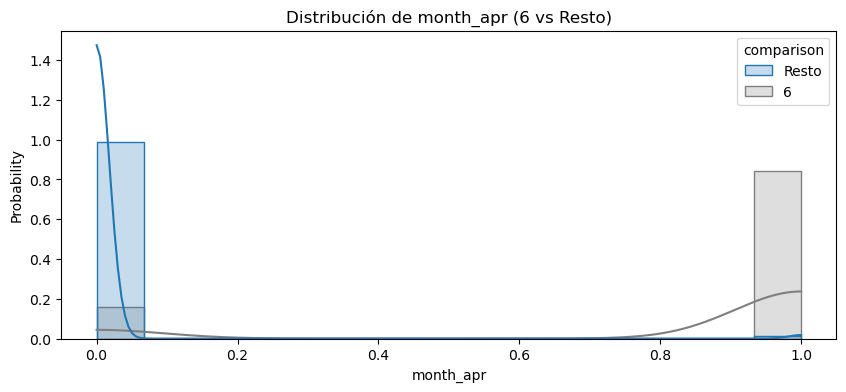

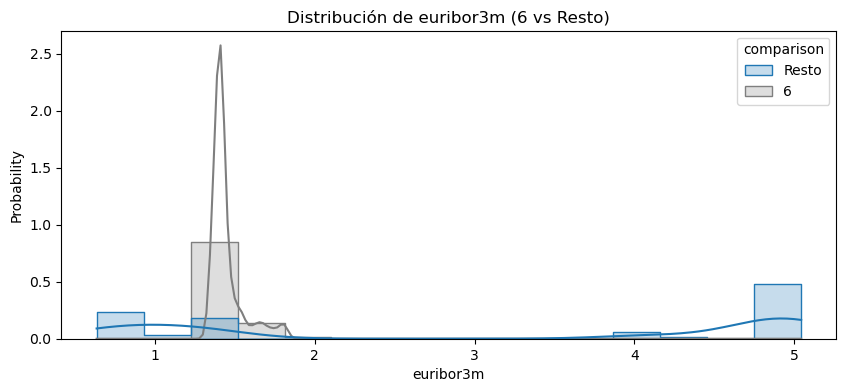


Comparando Cluster 7 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  7 |     13.02 |    43.3775 |       56.6225 |                   11.2955 |


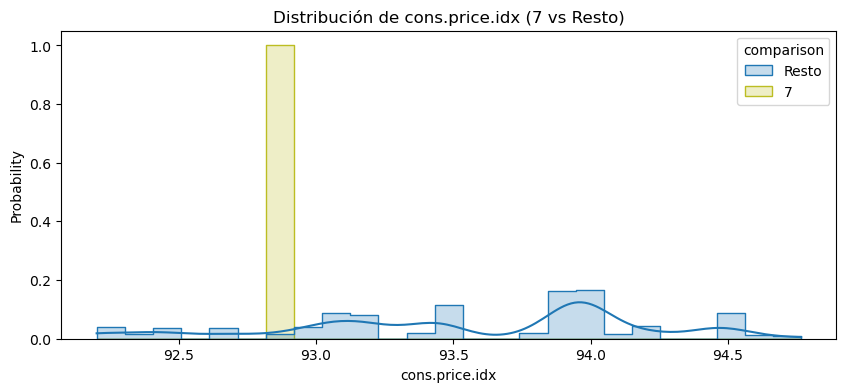

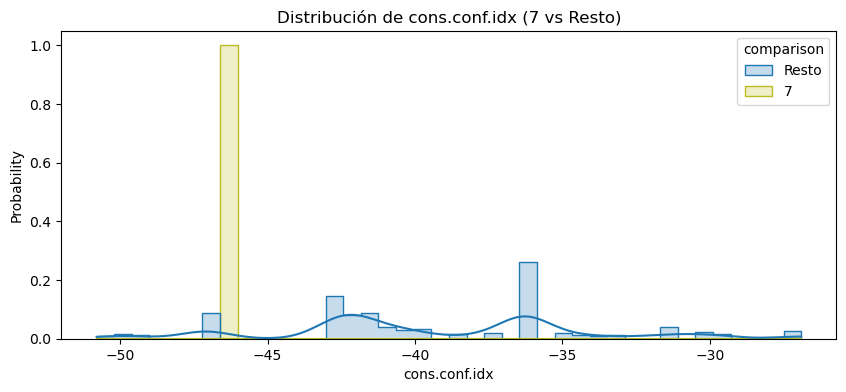

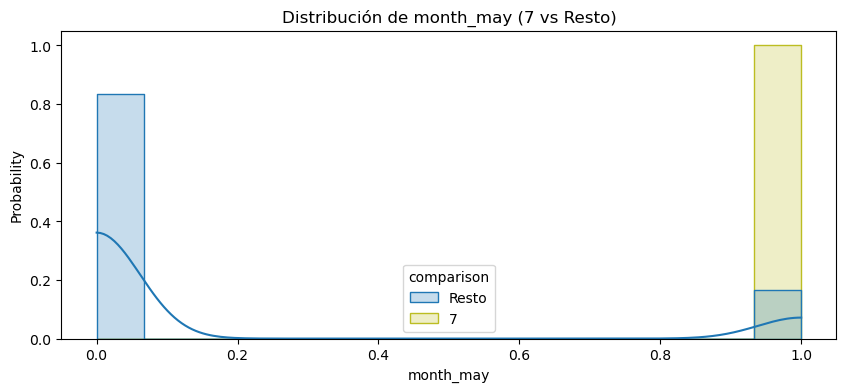


Comparando Cluster 8 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  8 |   9.78659 |    95.4846 |       4.51542 |                   18.6894 |


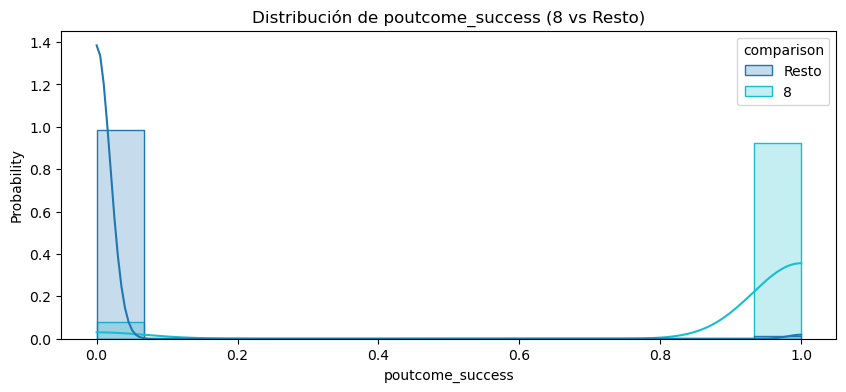

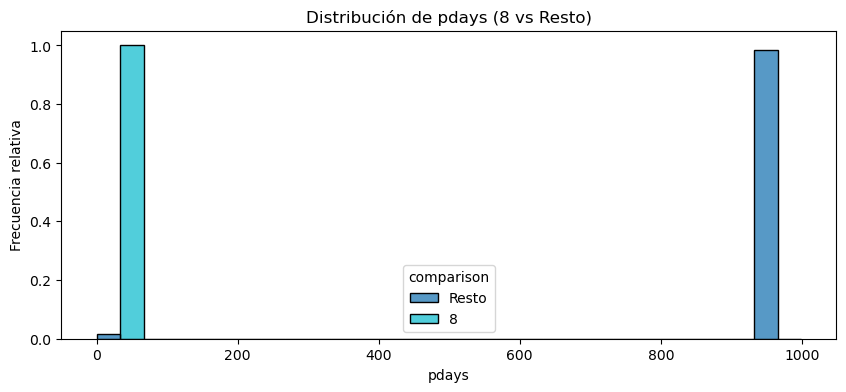

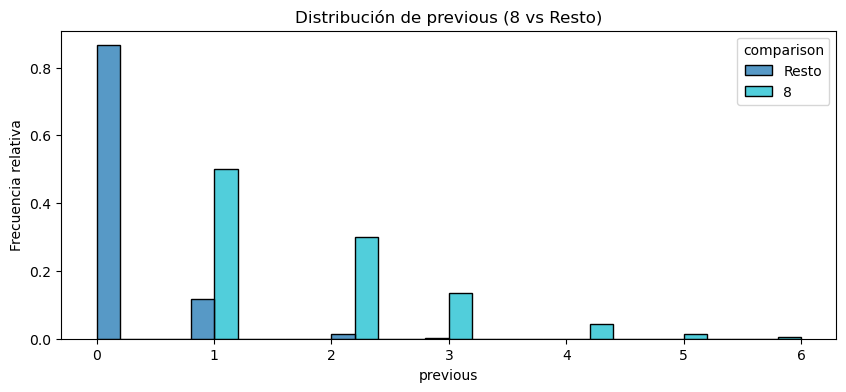


Comparando Cluster 9 contra el resto
|    |   Casos % |   Ventas % |   No-ventas % |   Ventas sobre el total % |
|---:|----------:|-----------:|--------------:|--------------------------:|
|  9 |   17.7732 |     81.322 |        18.678 |                   28.9071 |


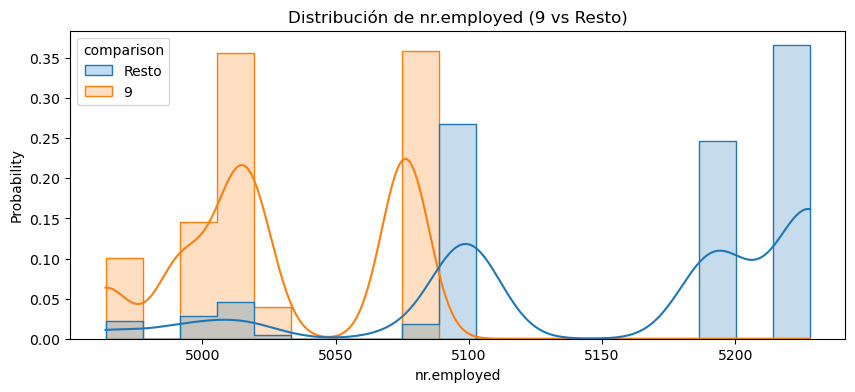

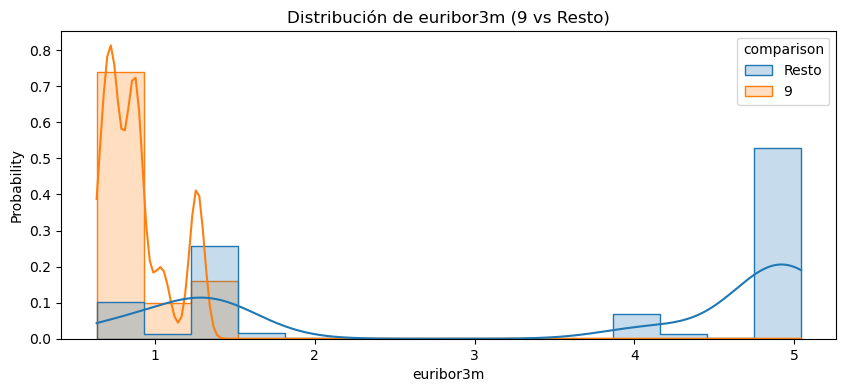

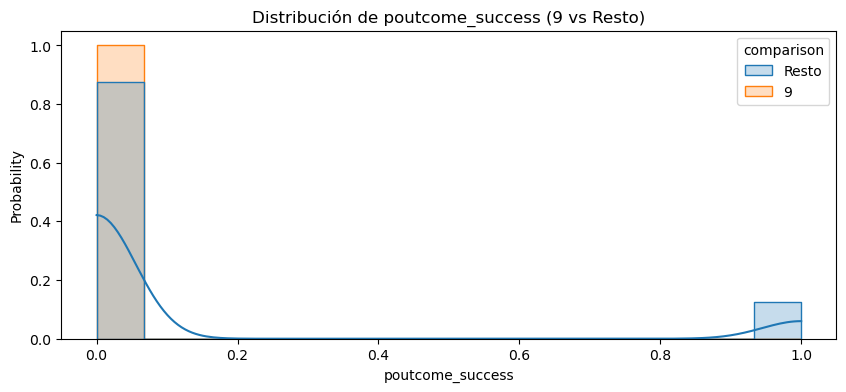

In [26]:
df_clusters_encoded = pd.get_dummies(df_clusters, columns=cat_features)

plot_distributions_by_cluster(df_clusters_encoded, 
                              important_features_by_cluster, 
                              target='cluster',
                              top_n=3, # para el análisis lo corrí con 5 
                              sample_frac=1, 
                              cluster_stats=cluster_stats,
                              variable_config=None)

### Conclusiones de la segmentación

#### Analizando los clusters con alta tasa de conversión (> 70 %)

Representan un 30 % de los prospectos y 52 % de las ventas {2, 8, 9}

**Venta cantada (cluster 8)**

10 % de los casos | 96 % de efectividad | 19 % de las ventas

+ poutcome_success 1 (se olfateaba la venta desde la campañia previa)
+ pdays & previous > 0 (varios contactos con 1 a 3 dias de espera)
+ eurobot3m ~ 1 % (momentos de baja tasa euribor)
+ nr.employed bajo (momento de crisis)

**Hoyo en uno (cluster 9)**

18 % de los casos | 81% de efectividad | 29 % de las ventas

+ nr.employed & emp.var.rate bajo (momento de crisis)
+ eurobot3m ~ 1 % (momentos de baja tasa euribor)
+ poutcome_success 0 (resultado del contacto previo no existente)
+ pdays 999 (sin contacto previo)

**Junio de ahorro (cluster 2)**

2 % de los casos | 80 % de efectividad | 4 % de las ventas

+ duration > 5 minutos (venta trabajada)
+ month_jun 1 (~todos en el mes de junio)
+ euribor 5 (~todos con alta tasa)
+ cons.conf, cons.price y nr.employed con *valores puntuales*

*Parece corresponder a un momento con buena tasa u otra condición positiva analizable desde lo ofrecido*

#### Analizando los clusters con baja tasa de conversión (< 30 %)

Representan un 28 % de los prospectos y 11 % de las ventas {0, 1, 4}

**Agosto anti-ahorro (cluster 4)**

10 % de los casos | 30 % de efectividad | 6 % de las ventas

- month_aug 1 (~todos en el mes de aug)
- euribor 5 (~todos con alta tasa)
- cons.conf, cons.price y nr.employed con *valores puntuales*

*Parece corresponder a un momento con mala tasa u otra condición negativa analizable desde lo ofrecido*

**Mayo anti-ahorro (cluster 0)**

13 % de los casos | 20 % de efectividad | 5 % de las ventas

Similar al anterior, pero con Mayo y todos contactos telefónicos.

*Parece corresponder a una campaña vieja, donde no se contactaba al celular del cliente*

**Junio anti-ahorro (cluster 1)**

5 % de los casos | 2 % de efectividad | 0 % de las ventas

Similar al anterior, pero con Junio y todos contactos telefónicos.

*Parece corresponder a un momento con mala tasa u otra condición negativa analizable desde lo ofrecido*


### Complejidad del caso

En este análisis rápido, pudimos identificar y describir ~50 % de las ventas, correspondientes al 30 % de los casos.

Luego, se detectaron meses puntuales con alta (cluster 2) y baja (cluster 4, 0, 1) efectividad de conversión. Para estos, la variables de contexto son muy estables, lo que sugiere que se trata del mismo mes, para lo que correspondería tener más información sobre la tasa ofrecida y alguna característica más de la situación que se vivía en Portugal en esos meses.

Luego, todavía tenemos la mitad de ventas pendientes, pensando en un enfoque predictivo. Esto demuestra la complejidad del caso y justifica avanzar sobre modelos de ML de ensamble y optimizados.



In [41]:
del df_ori
del df_under
del df_clusters
del df_clusters_encoded
del X_encoded
del X_rf

_____

____

## Algoritmo de ML

El estado del arte para este tipo de problemas de clasificación, usando datos tabulares, sigue siendo (desde hace unos años) la aplicación de modelos de ensamble. Las opciones más conocidas:

+ RandomForest (Bagging)
+ XGBoost (Boosting)
+ LightGBM (Boosting)

Experiencia:

LightGBM suele ser aclamado como el algorítmo de boosting superador, aunque en mi experiencia XGBoost suele ser mejor con datasets acotados (como este caso). RandomForest puede ser usado como baseline, aunque en este challenge voy a pasar por alto esta referencia para ir directo a la solución óptima.

In [2]:
from sklearn.model_selection import train_test_split
from modules.utils_opt import OptiPipeline

seed = 42

### Preparando datos

Aplicado el pre-procesamiento definido que, por ser muy sencillo, no vale la pena armar un pipeline.

### Train / Evaluation split

Aplico un split acotado al 10 % por la poca cantidad de datos. Esto debería ser considerando el orden temporal, para dejar para test los casos más recientes, si tuvieramos esa info.

In [3]:
# loading original data
data = pd.read_csv('data/bank-additional-full.csv', sep=';')

target_mapping = {'no': 0, 'yes': 1}
target = 'y'
data[target] = data[target].map(target_mapping)

# pre-processing
data.drop_duplicates(inplace=True)
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0)

# split acotado a la cantidad de datos
train_data, test_data = train_test_split(data, test_size=0.1, 
                                         random_state=seed, shuffle=True)
# split val / test
val_data, test_data = train_test_split(test_data, test_size=0.5, 
                                         random_state=seed, shuffle=True)

Reviso estratificación en y, aunque estadísticamente debería estar cubierto

In [4]:
train_data.y.value_counts(normalize=True)

y
0    0.887582
1    0.112418
Name: proportion, dtype: float64

In [5]:
val_data.y.value_counts(normalize=True)

y
0    0.879553
1    0.120447
Name: proportion, dtype: float64

In [6]:
test_data.y.value_counts(normalize=True)

y
0    0.890724
1    0.109276
Name: proportion, dtype: float64

In [7]:
test_data.to_csv('data/raw_testing_dataset.csv')

### One-hot encoding

In [8]:
X_train = train_data.drop([target], axis=1)
X_val = val_data.drop([target], axis=1)
X_test = test_data.drop([target], axis=1)

y_train = train_data[target]
y_val = val_data[target]
y_test = test_data[target]

num_features = X_train.select_dtypes(include=np.number).columns.tolist()
cat_features = X_train.drop(num_features, axis=1).columns.tolist()

X_train_encoded = pd.get_dummies(X_train, columns=cat_features, drop_first=True, dtype=int)
X_val_encoded = pd.get_dummies(X_val, columns=cat_features, drop_first=True, dtype=int)
X_test_encoded = pd.get_dummies(X_test, columns=cat_features, drop_first=True, dtype=int)

# para que los dummies de train, val y test coincidan
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

### Optimización bayesiana

Usando train y val

Optimizando ROC AUC, aunque podría hacerlo hecho con f1

Esto demora horas cuando trabajamos con datasets importantes, y suele convenir usar undersampleo de las clases negativas

Con 100 trials creo que será suficiente, aunque con datasets mayores > 300 sería comveniente

#### LightGBM

Optimizando la métrica precision-recall auc

Training base model as baseline
Base model trained
Base model validation
Base model pr-auc: 0.6942343580372514

Optimizing the model


[I 2024-12-15 18:11:41,817] Using an existing study with name 'exp_lgbm_local_v02' instead of creating a new one.


Best parameters for lightgbm: {'n_estimators': 339, 'num_leaves': 32, 'learning_rate': 0.012922749679677987, 'subsample': 0.9151554492556478, 'colsample_bytree': 0.7332824700309769}
Optimization complete

Comparing best model
Using only training data and several splits

Comparing models with the following configurations:
- Metric: pr-auc
- Test size: 0.1
- Base parameters: {'random_state': 42}
- Best parameters: {'n_estimators': 339, 'num_leaves': 32, 'learning_rate': 0.012922749679677987, 'subsample': 0.9151554492556478, 'colsample_bytree': 0.7332824700309769}
- Number of splits: 10
- Random state: 42
- Number of parallel jobs: -1


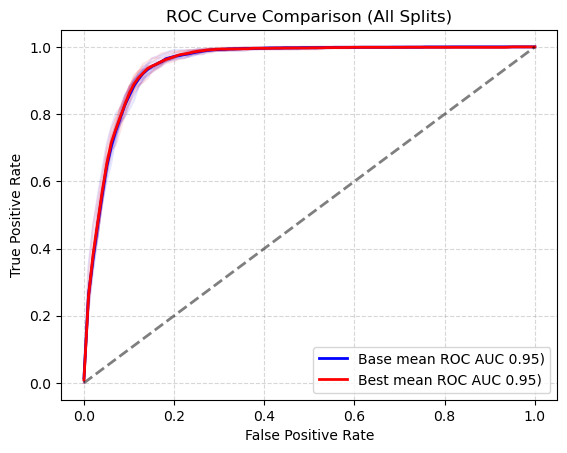

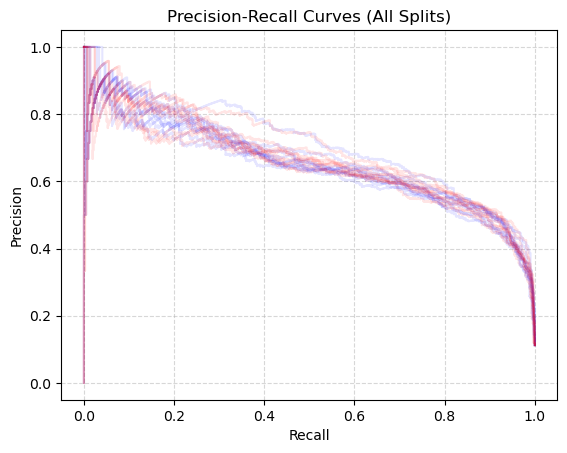

Base mean P-R AUC = 0.66
 Best mean P-R AUC = 0.66


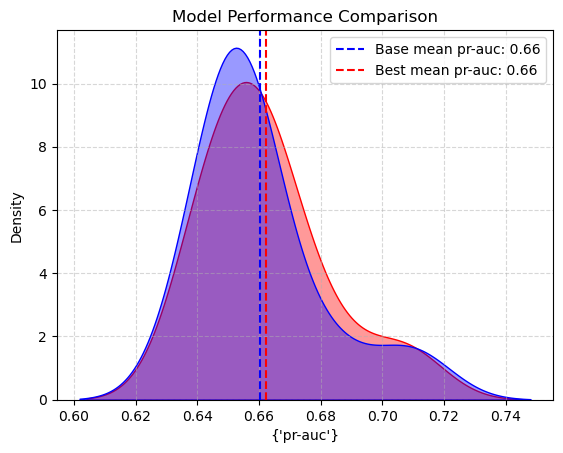

Base model mean pr-auc: 0.66
Best model mean pr-auc: 0.66

Training best model for validation
Validating model performance


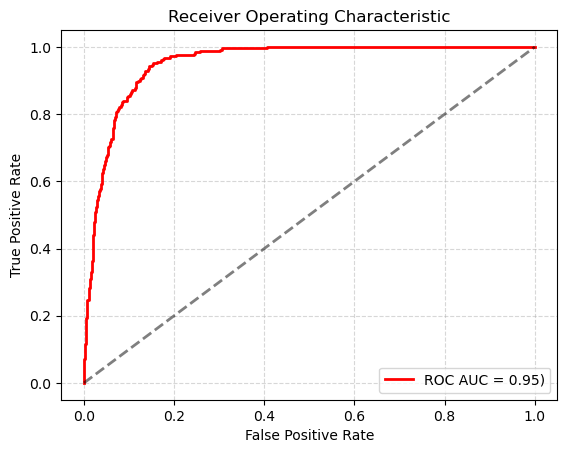

ROC AUC: 0.95


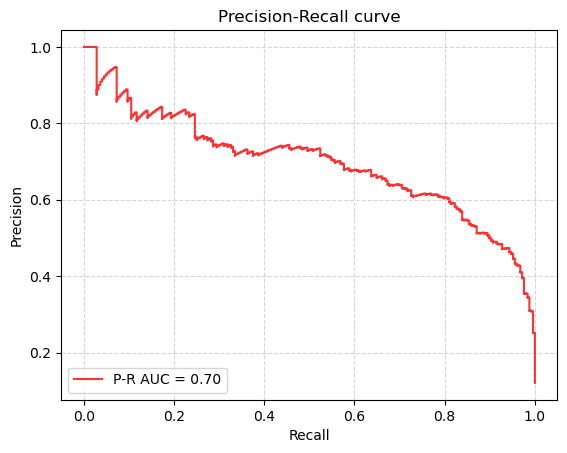

P-R AUC: 0.70


In [9]:
# Metrica
metric = 'pr-auc'

# Instanciar el pipeline
pipeline = OptiPipeline(data=None,metric=metric, model_type='lightgbm', 
                        seeds=[seed], n_jobs=-1)

# Entrenar el modelo base
print("Training base model as baseline")

pipeline.train_base_model(X_train_encoded, y_train)
print("Base model trained")

# Evaluar el modelo base
print("Base model validation")
base_score = pipeline.evaluate_model(pipeline.base_model, X_val_encoded, y_val, 
                                     plot_roc=False)

print(f"Base model {metric}: {base_score}\n")

# Almacenamiento de optuna
storage_name = "sqlite:///optimization/optimization_trees.db"
study_name = f"exp_lgbm_local_v02" #v00 con roc-auc, v01 con f1, v02 con pr-auc

print("Optimizing the model")

# Optimizar el modelo
best_params = pipeline.optimize_model(
    X=X_train_encoded, 
    y=y_train, 
    storage_name=storage_name, 
    study_name=study_name,
    n_trials=150,
    optimize=False,
)

print("Optimization complete\n")

print("Comparing best model")
print("Using only training data and several splits\n")
# Comparar ambos modelos con StratifiedShuffleSplit sobre el train
results_base, results_best = pipeline.compare_models(X_train_encoded, y_train, 
                                                     folds=10, test_size=0.1)

print("Training best model for validation")
# Entrenamiento final el modelo optimizado
pipeline.train_best_model(X_train_encoded, y_train)

print("Validating model performance")
# Validación el modelo optimizado
best_score = pipeline.evaluate_model(pipeline.best_model, X_val_encoded, y_val, 
                                     plot_roc=True, plot_pr=True)

OBSERVACIONES:

> El modelo se valida según resultados obtenidos: 0.66 en 10 StratifiedShuffleSplit del train, y 0.7 en los datos de validación. No se percibe señales de over-fitting.

> El under-fitting sí puede ser un síntoma, atribuible a la escaza cantidad de variables, sobre todo aquellas relacionadas con la "foto" de las cuentas y actividad bancaria de cada cliente.

NOTAS:

> Resta analizar la optimización con los métodos de visualización de optuna

> Comparar con Random Forest, como baseline primitivo

## Validación

La validación per se ya comenzó en el paso anterior, con las pruebas del modelo optimizado. Sin embargo, corresponde validar nuevamente el modelo, con una mirada más próxima al negocio:

### Ganancias vs. Costo

La ganancia de la entidad bancaria, por cada depósito/venta, debe ser calculada con datos que no están disponibles.

Además, sería bueno, para un modelo futuro contar con:

- Monto depositado
- Tasa de interés
- Margen de ganancia

Con esto, además de un modelo de clasificación (para mejorar la tasa de conversión/venta), podemos entrenar un modelo de regresión que estime cuanto estaría dispuesto a depositar cada cliente. Así, los esfuerzos se pondrían sobre los depósitos más importantes.

**Valores aproximados para un ejercicio conceptual sobre depósitos a plazo fijo en Portugal en 2024:**

- **Inversión en plazo fijo que puede hacer una persona promedio:** 5,000 €  
  *(Considerando un monto común accesible para la clase media en Portugal).*

- **Tasa de interés para depósitos a plazo fijo:** 3% anual  
  *(Un promedio razonable entre las tasas disponibles en el mercado).*

- **Tasa de ganancia del banco por ese depósito:** 2%  
  *(Basado en el margen de interés neto común para depósitos vs préstamos).*

- **Ganancia media por depósito:** 150 €  
  *(Para una inversión de 5,000 € al 3% anual, el cliente gana 150 € en un año).*

- **Costo de intento de venta medio estimado:** 20 €  
  *(Incluye costos de marketing, fuerza de ventas y soporte asociado al proceso de captación).*

In [10]:
from modules.utils_val import plot_ganancias_calls, plot_ganancias_thr
from modules.utils_val import plot_roc, plot_pr

In [11]:
ganancia_venta = 150 # Euros
costo_venta = 20 # Euros

In [12]:
val_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,not_working
18684,31,services,single,high.school,no,no,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0,0
13314,25,blue-collar,married,basic.9y,no,no,no,cellular,jul,wed,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,0
3503,57,retired,single,high.school,no,yes,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0,1
7921,42,services,divorced,high.school,unknown,yes,no,telephone,jun,mon,...,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,0,0
31135,31,blue-collar,single,high.school,no,no,no,cellular,may,wed,...,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27858,32,admin.,single,professional.course,no,yes,yes,cellular,mar,tue,...,999,0,nonexistent,-1.8,92.843,-50.0,1.614,5099.1,0,0
11853,33,blue-collar,married,basic.9y,no,no,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,0
30940,42,entrepreneur,divorced,professional.course,no,yes,no,cellular,may,tue,...,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,0,0
22797,47,blue-collar,married,basic.9y,no,no,no,cellular,aug,mon,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0,0


### Estimacación del corte & umbral óptimo

Cuantos intentos de venta resulta óptimo en términos de ganancia?

En un conjunto de prospectos dado: 

+ **validación** con 2059 clientes, suponiendo que estos el grupo de clientes objetivo para una semana dada.

NOTA:

> Sería mejor trabajar con un set mejor definido semanal o mensualmente, o con más información del presupuesto de llamadas o intentos de venta, o del equipo de ventas que estará operativo.


#### Entrenamiento variando random_state

Usaremos 20 semillas, con el modelo optimizado

In [13]:
from lightgbm import LGBMClassifier

In [14]:
val_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,not_working
18684,31,services,single,high.school,no,no,no,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0,0
13314,25,blue-collar,married,basic.9y,no,no,no,cellular,jul,wed,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,0
3503,57,retired,single,high.school,no,yes,no,telephone,may,thu,...,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,0,1
7921,42,services,divorced,high.school,unknown,yes,no,telephone,jun,mon,...,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,0,0
31135,31,blue-collar,single,high.school,no,no,no,cellular,may,wed,...,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27858,32,admin.,single,professional.course,no,yes,yes,cellular,mar,tue,...,999,0,nonexistent,-1.8,92.843,-50.0,1.614,5099.1,0,0
11853,33,blue-collar,married,basic.9y,no,no,no,telephone,jun,fri,...,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,0,0
30940,42,entrepreneur,divorced,professional.course,no,yes,no,cellular,may,tue,...,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,0,0
22797,47,blue-collar,married,basic.9y,no,no,no,cellular,aug,mon,...,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,0,0


In [15]:
def calc_ganancia(y, y_proba, thr, ganancia_venta=150, costo_venta=20):
    
    results = np.where(y_proba >= thr, np.where(y == 1, ganancia_venta, -costo_venta), 0)
    return results.sum()

def count_calls(y_proba, thr):
    return np.where(y_proba >= thr, 1, 0).sum()

def calc_ganancia_by_calls(y, y_proba, max_calls, ganancia_venta=150, costo_venta=20):
    # Ordenar las probabilidades y sus índices en orden descendente
    sorted_indices = np.argsort(-y_proba)
    
    # Seleccionar los índices correspondientes a las max_calls
    top_indices = sorted_indices[:max_calls]

    # Calcular el threshold correspondiente (mínima probabilidad en el top)
    threshold = y_proba[top_indices[-1]] if len(top_indices) == max_calls else 0

    # Calcular los resultados basados en las max_calls seleccionadas
    results = np.zeros_like(y, dtype=int)
    results[top_indices] = np.where(y[top_indices] == 1, ganancia_venta, -costo_venta)

    # Calcular ganancia total
    total_gain = results.sum()

    return total_gain, threshold

In [16]:
# Definición del modelo optimo
params = best_params

params.update({'n_jobs': -1})

# Entrenamiento 
print("Running semillerío") 
print("para contemplar la variabilidad que maneja el algoritmo de entrenamiento")
print(params)

# Registrar las probabilidades
df_sem_proba = pd.DataFrame({
                            'client': val_data.index,
                        })

# Registrar resultados según thr
df_results_by_thr = pd.DataFrame()

# Registrar resultados según calls
df_results_by_calls = pd.DataFrame()

j = 0
s_r = range(217163, 455783, 7*7*7*7*5) # 20 semillas
# s_r = list(range(3)) # 3 semillas de prueba

s_total = len(list(s_r))
for s in s_r:
    # nueva instancia del modelos con semilla
    seed = s + (7+j)
    model = LGBMClassifier(**params, random_state=seed)
    # entreno
    print(f"Entrenando modelo con semilla: {seed}, {j+1} de {s_total}")
    model.fit(X_train_encoded, y_train)
    # predigo proba
    y_pred_proba = model.predict_proba(X_val_encoded)
    # proba baja+2
    proba = y_pred_proba[:,1]
    df_sem_proba[f'proba_s{seed}'] = proba
    
    # ganancias según threshold
    thrs = []
    ganancias = []
    total_calls = []
    for thr in np.linspace(0.05, 0.25, 1000):
        gain = calc_ganancia(val_data.y, proba, thr)
        calls = count_calls(proba, thr)
        thrs.append(thr)
        ganancias.append(gain)
        total_calls.append(calls)
    
    df_results_by_thr[f'threshold'] = thrs
    df_results_by_thr[f'ganancias_{seed}'] = ganancias
    df_results_by_thr[f'total_calls_{seed}'] = total_calls

    # ganancias según calls
    total_calls = []
    ganancias = []
    thrs = []
    for calls in range(400, 700):
        gain, thr = calc_ganancia_by_calls(val_data.y.values, proba, calls)
        thrs.append(thr)
        ganancias.append(gain)
        total_calls.append(calls)
    
    df_results_by_calls[f'total_calls'] = total_calls
    df_results_by_calls[f'threshold_{seed}'] = thrs
    df_results_by_calls[f'ganancias_{seed}'] = ganancias

    j += 1

Running semillerío
para contemplar la variabilidad que maneja el algoritmo de entrenamiento
{'n_estimators': 339, 'num_leaves': 32, 'learning_rate': 0.012922749679677987, 'subsample': 0.9151554492556478, 'colsample_bytree': 0.7332824700309769, 'n_jobs': -1}
Entrenando modelo con semilla: 217170, 1 de 20
Entrenando modelo con semilla: 229176, 2 de 20
Entrenando modelo con semilla: 241182, 3 de 20
Entrenando modelo con semilla: 253188, 4 de 20
Entrenando modelo con semilla: 265194, 5 de 20
Entrenando modelo con semilla: 277200, 6 de 20
Entrenando modelo con semilla: 289206, 7 de 20
Entrenando modelo con semilla: 301212, 8 de 20
Entrenando modelo con semilla: 313218, 9 de 20
Entrenando modelo con semilla: 325224, 10 de 20
Entrenando modelo con semilla: 337230, 11 de 20
Entrenando modelo con semilla: 349236, 12 de 20
Entrenando modelo con semilla: 361242, 13 de 20
Entrenando modelo con semilla: 373248, 14 de 20
Entrenando modelo con semilla: 385254, 15 de 20
Entrenando modelo con semilla: 

In [17]:
df_sem_proba.head(5)

,client,proba_s217170,proba_s229176,proba_s241182,proba_s253188,proba_s265194,proba_s277200,proba_s289206,proba_s301212,proba_s313218,...,proba_s337230,proba_s349236,proba_s361242,proba_s373248,proba_s385254,proba_s397260,proba_s409266,proba_s421272,proba_s433278,proba_s445284
0,18684,0.003541,0.003277,0.003461,0.003573,0.003848,0.003147,0.003147,0.003414,0.003639,...,0.003010,0.003114,0.003722,0.003351,0.003094,0.003704,0.003699,0.003315,0.003849,0.003083
1,13314,0.005467,0.004376,0.004945,0.004350,0.005650,0.004865,0.004311,0.005064,0.004642,...,0.004501,0.005042,0.005710,0.004670,0.004134,0.005428,0.005056,0.005300,0.004742,0.004461
2,3503,0.044693,0.043678,0.044306,0.042042,0.047001,0.048865,0.045562,0.051953,0.044755,...,0.045679,0.044584,0.047216,0.047506,0.045803,0.048478,0.048206,0.047780,0.048307,0.045608
3,7921,0.004607,0.003858,0.004061,0.003824,0.004471,0.004077,0.003716,0.004309,0.003941,...,0.004037,0.004190,0.004400,0.003968,0.003633,0.004359,0.004063,0.004317,0.004095,0.003837
4,31135,0.007677,0.007085,0.007807,0.007327,0.008097,0.007961,0.006866,0.007595,0.007119,...,0.007157,0.007630,0.008169,0.007424,0.007411,0.007605,0.007841,0.007468,0.007149,0.007070


In [18]:
df_results_by_calls.head(5)

,total_calls,threshold_217170,ganancias_217170,threshold_229176,ganancias_229176,threshold_241182,ganancias_241182,threshold_253188,ganancias_253188,threshold_265194,...,threshold_397260,ganancias_397260,threshold_409266,ganancias_409266,threshold_421272,ganancias_421272,threshold_433278,ganancias_433278,threshold_445284,ganancias_445284
0,400,0.214523,27870,0.220420,28380,0.218479,28380,0.217155,28380,0.218420,...,0.220739,28550,0.219784,28550,0.215593,28550,0.213303,28210,0.221034,28550
1,401,0.211513,28020,0.218650,28530,0.217160,28360,0.216234,28360,0.218141,...,0.217713,28530,0.218594,28530,0.215079,28530,0.213064,28190,0.220560,28530
2,402,0.211011,28000,0.216940,28510,0.216989,28340,0.215159,28340,0.214155,...,0.215988,28510,0.217685,28510,0.213230,28510,0.212847,28340,0.218087,28510
3,403,0.210898,28150,0.216785,28490,0.216232,28490,0.214132,28320,0.213611,...,0.214029,28490,0.215224,28490,0.212274,28490,0.210376,28320,0.217054,28490
4,404,0.207116,28130,0.215180,28470,0.214127,28470,0.214075,28300,0.213297,...,0.213967,28470,0.214446,28470,0.211676,28470,0.209022,28300,0.216385,28470


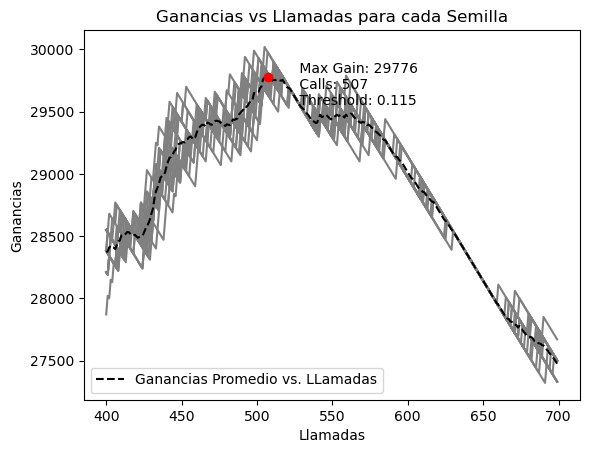

In [19]:
plot_ganancias_calls(df_results_by_calls)

In [20]:
df_results_by_thr.head(5)

,threshold,ganancias_217170,total_calls_217170,ganancias_229176,total_calls_229176,ganancias_241182,total_calls_241182,ganancias_253188,total_calls_253188,ganancias_265194,...,ganancias_397260,total_calls_397260,ganancias_409266,total_calls_409266,ganancias_421272,total_calls_421272,ganancias_433278,total_calls_433278,ganancias_445284,total_calls_445284
0,0.050000,28500,632,28560,629,28520,631,28560,629,28460,...,28460,634,28460,634,28460,634,28500,632,28480,633
1,0.050200,28520,631,28580,628,28540,630,28560,629,28460,...,28460,634,28500,632,28460,634,28520,631,28500,632
2,0.050400,28520,631,28580,628,28540,630,28560,629,28460,...,28480,633,28500,632,28480,633,28540,630,28520,631
3,0.050601,28560,629,28600,627,28560,629,28560,629,28460,...,28480,633,28540,630,28500,632,28580,628,28520,631
4,0.050801,28560,629,28640,625,28560,629,28600,627,28500,...,28480,633,28540,630,28520,631,28600,627,28540,630


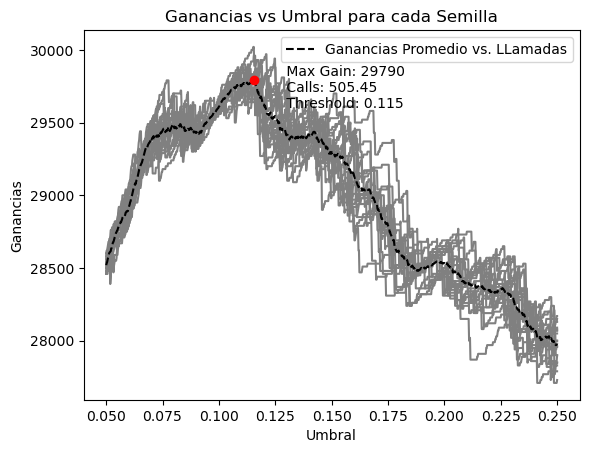

In [21]:
plot_ganancias_thr(df_results_by_thr)

## Prueba final

La prueba final pretende demostrar la capacidad del modelo de generalizar a nuevos.

Por esto, usaremos el split de testing para evaluar el performance del modelo y compararlo con la validación previa.

El entramiento se hará combinando train y val:

In [22]:
X_train_total_encoded = pd.concat([X_train_encoded, X_val_encoded])
y_train_total = pd.concat([y_train, y_val])

In [23]:
import json
import datetime

# Definición del modelo optimo
params = best_params
params.update({'n_jobs': -1})

# Fecha
ft = "%dT-%m-%Y%H-%M-%S"
t_now = datetime.datetime.now().strftime(ft)

# Guardando metadata
meta = {
    'model': 'LGBMClassifier',
    'package': 'lightgbm==4.5.0',
    'date': t_now,
    'opt_metric': metric,
    'val_score': best_score,
    'storage_name': storage_name,
    'study_name': study_name,
    'params': params,
    'cat_to1h': cat_features,
}

with open('models/metadata.json', 'w') as file:
    json.dump(meta, file, indent=4)

meta

{'model': 'LGBMClassifier',
 'package': 'lightgbm==4.5.0',
 'date': '15T-12-202418-12-06',
 'opt_metric': 'pr-auc',
 'val_score': 0.6975212709325839,
 'storage_name': 'sqlite:///optimization/optimization_trees.db',
 'study_name': 'exp_lgbm_local_v02',
 'params': {'n_estimators': 339,
  'num_leaves': 32,
  'learning_rate': 0.012922749679677987,
  'subsample': 0.9151554492556478,
  'colsample_bytree': 0.7332824700309769,
  'n_jobs': -1},
 'cat_to1h': ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome']}

In [24]:
import joblib

# Entrenamiento 
print("Running semillerío") 
print("para mitigar el efecto de la variabilidad del algoritmo de entrenamiento")
print(params)

# Registrar las probabilidades
df_sem_proba = pd.DataFrame({
                            'client': test_data.index,
                        })

# Registrar resultados según thr
df_results_by_thr = pd.DataFrame()

# Registrar resultados según calls
df_results_by_calls = pd.DataFrame()

j = 0
s_r = range(217163, 455783, 7*7*7*7*5) # 20 semillas
# s_r = list(range(3)) # 3 semillas de prueba

s_total = len(list(s_r))
for s in s_r:
    # nueva instancia del modelos con semilla
    seed = s + (7+j)
    model = LGBMClassifier(**params, random_state=seed)
    # entreno
    print(f"Entrenando modelo con semilla: {seed}, {j+1} de {s_total}")
    model.fit(X_train_total_encoded, y_train_total)
    # predigo proba
    y_pred_proba = model.predict_proba(X_test_encoded)
    proba = y_pred_proba[:,1]
    df_sem_proba[f'proba_s{seed}'] = proba
    
    # guardo modelo
    joblib.dump(model, f'models/model_s{seed}.pkl')

    # ganancias según threshold
    thrs = []
    ganancias = []
    total_calls = []
    for thr in np.linspace(0.05, 0.25, 1000):
        gain = calc_ganancia(test_data.y, proba, thr)
        calls = count_calls(proba, thr)
        thrs.append(thr)
        ganancias.append(gain)
        total_calls.append(calls)
    
    df_results_by_thr[f'threshold'] = thrs
    df_results_by_thr[f'ganancias_{seed}'] = ganancias
    df_results_by_thr[f'total_calls_{seed}'] = total_calls

    # ganancias según calls
    total_calls = []
    ganancias = []
    thrs = []
    for calls in range(400, 700):
        gain, thr = calc_ganancia_by_calls(test_data.y.values, proba, calls)
        thrs.append(thr)
        ganancias.append(gain)
        total_calls.append(calls)
    
    df_results_by_calls[f'total_calls'] = total_calls
    df_results_by_calls[f'threshold_{seed}'] = thrs
    df_results_by_calls[f'ganancias_{seed}'] = ganancias

    j += 1

# Promediando proba de cada semilla
proba_s_columns = df_sem_proba.filter(regex='^proba_s')
proba_s_mean = proba_s_columns.mean(axis=1)

df_sem_proba['proba_sem_mean'] = proba_s_mean

Running semillerío
para mitigar el efecto de la variabilidad del algoritmo de entrenamiento
{'n_estimators': 339, 'num_leaves': 32, 'learning_rate': 0.012922749679677987, 'subsample': 0.9151554492556478, 'colsample_bytree': 0.7332824700309769, 'n_jobs': -1}
Entrenando modelo con semilla: 217170, 1 de 20
Entrenando modelo con semilla: 229176, 2 de 20
Entrenando modelo con semilla: 241182, 3 de 20
Entrenando modelo con semilla: 253188, 4 de 20
Entrenando modelo con semilla: 265194, 5 de 20
Entrenando modelo con semilla: 277200, 6 de 20
Entrenando modelo con semilla: 289206, 7 de 20
Entrenando modelo con semilla: 301212, 8 de 20
Entrenando modelo con semilla: 313218, 9 de 20
Entrenando modelo con semilla: 325224, 10 de 20
Entrenando modelo con semilla: 337230, 11 de 20
Entrenando modelo con semilla: 349236, 12 de 20
Entrenando modelo con semilla: 361242, 13 de 20
Entrenando modelo con semilla: 373248, 14 de 20
Entrenando modelo con semilla: 385254, 15 de 20
Entrenando modelo con semilla: 

### Metricas en prueba final

Evaluación según ganancia semanal, tomando como presupuesto

**510 llamadas**

In [32]:
presupuesto = 510 #llamadas

gain, thrs = calc_ganancia_by_calls(y_test.values, proba_s_mean.values, 510)

print(f"Ganancia obtenida para {presupuesto} llamadas: {gain} $EU")

Ganancia obtenida para 510 llamadas: 26010 $EU


Analisis de la campaña

In [49]:
thr

0.03096974130562055

### Vi que tenia mal el threshol en la siguiente celda:

AHORA DA MUCHO MEJOR INCLUSO

In [50]:
campaña = pd.DataFrame({
    'client': y_test.index,
    'result': np.where(proba_s_mean.values >= thrs, np.where(y_test.values == 1, 'Venta', 'No-venta'),\
                        np.where(y_test.values == 1, 'Venta-perdida', 0))
    })

campaña.result.value_counts(normalize=False)

result
0                1537
No-venta          297
Venta             213
Venta-perdida      12
Name: count, dtype: int64

In [51]:
campaña.result.value_counts(normalize=True)

result
0                0.746479
No-venta         0.144245
Venta            0.103448
Venta-perdida    0.005828
Name: proportion, dtype: float64

SALVO POR ESTO, QUE LAS VENTA-PERDIDA QUEDÓ EN 2.3 %

In [52]:
campaña[campaña['result']  != '0'].result.value_counts(normalize=True)

result
No-venta         0.568966
Venta            0.408046
Venta-perdida    0.022989
Name: proportion, dtype: float64

### Resultados operativos

Este modelo permitiría:

+ X4 la efectividad en los intentos de venta

+ Reducir > 70 % los llamados sin chances de éxito

+ Una ganancia estimada semanal de > 26 mil $EU

______

### Curvas sobre la prueba final

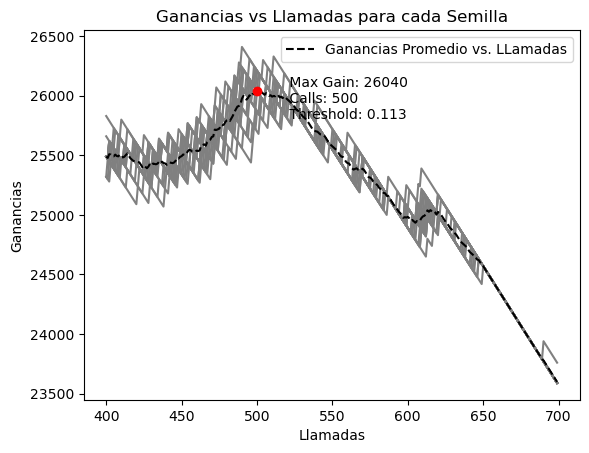

In [58]:
plot_ganancias_calls(df_results_by_calls)

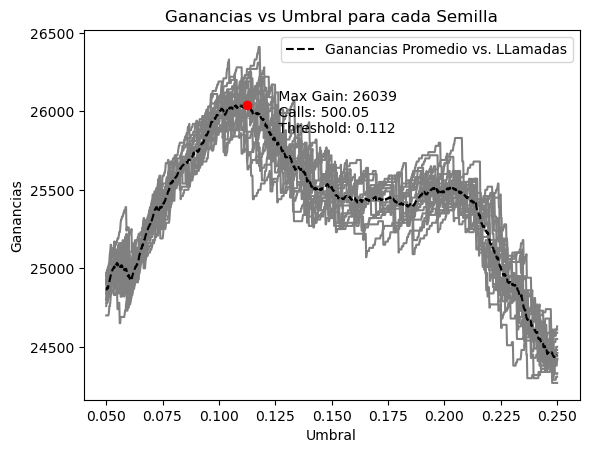

In [59]:
plot_ganancias_thr(df_results_by_thr)

### Evaluación técnica de la semilla promedio

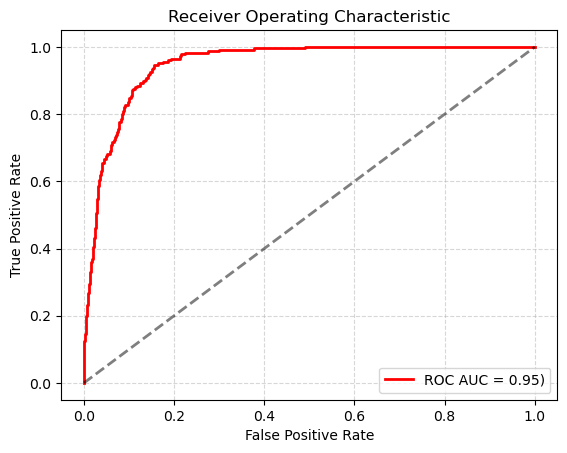

ROC AUC: 0.95


In [47]:
plot_roc(y_test, proba_s_mean)

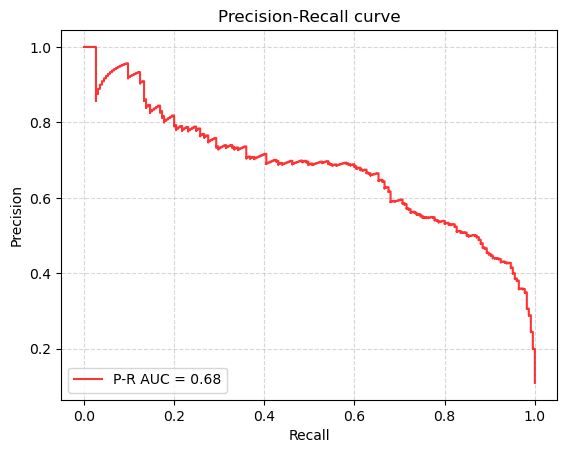

P-R AUC: 0.68


In [48]:
plot_pr(y_test, proba_s_mean)

_____

## Mejoras a futuro

> Mejorar el dataset: 

+ Agregando datos históricos de los clientes (actividad, montos, productos, etc.)

+ Sumando variables de fecha, así predecir sobre la información reciente de los clientes

> Revisar la segmentación con nuevas variables, para poder diseñar productos dedicados a cada cluster definido

> Aplicar SHAP u otro algoritmo de explicabilidad

> Adaptar el ejercicio a las necesidades del negocio

> Hacer una mejor estimación de ganancias y costos